In [6]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install -t . numpy scipy scikit-learn

    100% |████████████████████████████████| 12.1MB 102kB/s eta 0:00:01
    100% |████████████████████████████████| 46.7MB 26kB/s  eta 0:00:01
    100% |████████████████████████████████| 12.2MB 101kB/s eta 0:00:01


In [47]:
import sys
!{sys.executable} -m pip install statistics

  Running setup.py bdist_wheel for statistics ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/57/4b/23/14a5c991d6718a8ca1c708a414b7686b0cd33418f210512db3
Successfully built statistics


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [1]:
%matplotlib inline
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageFile
from urllib2 import urlopen
from django.core.validators import URLValidator
from django.core.exceptions import ValidationError
from sklearn.externals import joblib


import keras
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from collections import defaultdict
import pickle
from sklearn import preprocessing

/home/ubuntu/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()


def is_url(url):
    val = URLValidator()
    try:
        val(url)
        return True
    except ValidationError as e:
        return False
    
def plot_channels(img):
    _ , ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(24, 6))
    plt.suptitle('RBG Channels of an Image', size=20)
    
    np_img_r = np_img.copy()
    np_img_r[:, :, 1] = np.zeros(shape=[img_height, img_width])
    np_img_r[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[0].imshow(np_img_r)
    ax[0].axis('off')
    
    np_img_g = np_img.copy()
    np_img_g[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_g[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[1].imshow(np_img_g)
    ax[1].axis('off')
    
    np_img_b = np_img.copy()
    np_img_b[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_b[:, :, 1] = np.zeros(shape=[img_height, img_width])
    ax[2].imshow(np_img_b)
    ax[2].axis('off')


def read_img_url(url):
    file = urlopen(url)

    img = Image.open(file)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def read_img_file(f):
    img = Image.open(f)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def read_img(f):
    if is_url(f):
        img = read_img_url(f)
    else:
        img = read_img_file(f)
    
    return img

def resize_img_to_array(img, img_shape=(244, 244)):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

def make_resnet_conv(input_shape):
    '''
    Creates a ResNet50 model trained on ImageNet.
    It includes no final activation function,
    so model returns conv. features.
    
    `input_shape` is a tuple of integers.
    '''
    model = ResNet50(input_shape=input_shape, 
                     weights='imagenet', 
                     include_top=False)
    for layer in model.layers:
        layer.trainable = False   
    
    return model

In [4]:
def get_conv_feat(f, model):
    '''
    For any given image (file or url),
    convert to NumPy Array, resize to img_width x img_height,
    preprocess the values for ResNet, get the convolutional features
    from ResNet, and flatten the output.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    X_conv_2d = X_conv[0].flatten()
        
    return X_conv_2d

In [9]:
img_width, img_height = 299, 299
#model_2 = make_resnet_conv(input_shape=[img_width, img_height, 3])
i = 0
CATEGORY = 6
datadir = "/home/ubuntu/data"
# tri_url_map = defaultdict(list)
# tri_feat_map = defaultdict(list)
triplet_count = 0
img_count = 0
for subdir, dirs, files in os.walk(datadir):
    for img in files: 
        if ".DS_" in img: continue
        path = subdir+"/" +img
        path_split = path.split("/")
        index = int(path_split[-1].split(".")[0])
        print path
#         tri_url_map[index].append(path)
        #feat = get_conv_feat(path, model_2)
        img_count += 1
#         tri_feat_map[index].append(feat)
#         if len(tri_feat_map[index]) == 3: 
#             triplet_count += 1
#         if img_count % 1000 == 0: print "img_count: ", img_count, " urls: ", len(tri_url_map), " triplets: ", triplet_count
#         if img_count > 0 and img_count % 10000 == 0:
#             pickle.dump( tri_feat_map, open( "feats_pickle.p", "wb" ))
#             pickle.dump( tri_url_map, open( "url_pickle.p", "wb" ))
#             print "pickle dumped: img_count: ", img_count
#         if triplet_count > 0 and triplet_count % 1000 == 0: print triplet_count    
#delete_model(model_2)

/home/ubuntu/data/train/anchors/11887397967/13955.jpg
/home/ubuntu/data/train/anchors/11887397967/13892.jpg
/home/ubuntu/data/train/anchors/11887397967/14008.jpg
/home/ubuntu/data/train/anchors/11887397967/13970.jpg
/home/ubuntu/data/train/anchors/11887397967/13817.jpg
/home/ubuntu/data/train/anchors/11887397967/14031.jpg
/home/ubuntu/data/train/anchors/11887397967/14088.jpg
/home/ubuntu/data/train/anchors/11887397967/13927.jpg
/home/ubuntu/data/train/anchors/11887397967/14049.jpg
/home/ubuntu/data/train/anchors/11887397967/13959.jpg
/home/ubuntu/data/train/anchors/11887397967/14121.jpg
/home/ubuntu/data/train/anchors/11887397967/13987.jpg
/home/ubuntu/data/train/anchors/11887397967/14054.jpg
/home/ubuntu/data/train/anchors/11887397967/14127.jpg
/home/ubuntu/data/train/anchors/11887397967/14109.jpg
/home/ubuntu/data/train/anchors/11887397967/13832.jpg
/home/ubuntu/data/train/anchors/11887397967/14070.jpg
/home/ubuntu/data/train/anchors/11887397967/13956.jpg
/home/ubuntu/data/train/anch

/home/ubuntu/data/train/anchors/77866139663/29131.jpg
/home/ubuntu/data/train/anchors/77866139663/28931.jpg
/home/ubuntu/data/train/anchors/77866139663/28858.jpg
/home/ubuntu/data/train/anchors/77866139663/28676.jpg
/home/ubuntu/data/train/anchors/77866139663/28428.jpg
/home/ubuntu/data/train/anchors/77866139663/29288.jpg
/home/ubuntu/data/train/anchors/77866139663/29124.jpg
/home/ubuntu/data/train/anchors/77866139663/29181.jpg
/home/ubuntu/data/train/anchors/77866139663/29342.jpg
/home/ubuntu/data/train/anchors/77866139663/28624.jpg
/home/ubuntu/data/train/anchors/77866139663/28895.jpg
/home/ubuntu/data/train/anchors/77866139663/29427.jpg
/home/ubuntu/data/train/anchors/77866139663/28596.jpg
/home/ubuntu/data/train/anchors/77866139663/28508.jpg
/home/ubuntu/data/train/anchors/77866139663/28514.jpg
/home/ubuntu/data/train/anchors/77866139663/29118.jpg
/home/ubuntu/data/train/anchors/77866139663/29321.jpg
/home/ubuntu/data/train/anchors/77866139663/28898.jpg
/home/ubuntu/data/train/anch

/home/ubuntu/data/train/anchors/tumi-crop-top/43852.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43825.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/44071.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43928.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43883.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43934.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/44139.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43940.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43830.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43962.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43918.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43908.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43895.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/44106.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43957.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/44034.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43818.jpg
/home/ubuntu/data/train/anchors/tumi-crop-top/43

/home/ubuntu/data/train/anchors/11887371535/13232.jpg
/home/ubuntu/data/train/anchors/11887371535/13766.jpg
/home/ubuntu/data/train/anchors/11887371535/13327.jpg
/home/ubuntu/data/train/anchors/11887371535/13499.jpg
/home/ubuntu/data/train/anchors/11887371535/13678.jpg
/home/ubuntu/data/train/anchors/11887371535/13417.jpg
/home/ubuntu/data/train/anchors/11887371535/13225.jpg
/home/ubuntu/data/train/anchors/11887371535/13383.jpg
/home/ubuntu/data/train/anchors/11887371535/13715.jpg
/home/ubuntu/data/train/anchors/11887371535/13543.jpg
/home/ubuntu/data/train/anchors/11887371535/13530.jpg
/home/ubuntu/data/train/anchors/11887371535/13456.jpg
/home/ubuntu/data/train/anchors/11887371535/13555.jpg
/home/ubuntu/data/train/anchors/11887371535/13693.jpg
/home/ubuntu/data/train/anchors/11887371535/13765.jpg
/home/ubuntu/data/train/anchors/11887371535/13255.jpg
/home/ubuntu/data/train/anchors/11887371535/13494.jpg
/home/ubuntu/data/train/anchors/11887371535/13299.jpg
/home/ubuntu/data/train/anch

/home/ubuntu/data/train/anchors/6957514309zd/18760.jpg
/home/ubuntu/data/train/anchors/6957514309zd/18746.jpg
/home/ubuntu/data/train/anchors/6957514309zd/18722.jpg
/home/ubuntu/data/train/anchors/11337389455/22838.jpg
/home/ubuntu/data/train/anchors/11337389455/22810.jpg
/home/ubuntu/data/train/anchors/11337389455/22873.jpg
/home/ubuntu/data/train/anchors/11337389455/22812.jpg
/home/ubuntu/data/train/anchors/11337389455/22954.jpg
/home/ubuntu/data/train/anchors/11337389455/22933.jpg
/home/ubuntu/data/train/anchors/11337389455/22977.jpg
/home/ubuntu/data/train/anchors/11337389455/22924.jpg
/home/ubuntu/data/train/anchors/11337389455/22918.jpg
/home/ubuntu/data/train/anchors/11337389455/22938.jpg
/home/ubuntu/data/train/anchors/11337389455/22807.jpg
/home/ubuntu/data/train/anchors/11337389455/22835.jpg
/home/ubuntu/data/train/anchors/11337389455/22856.jpg
/home/ubuntu/data/train/anchors/11337389455/22907.jpg
/home/ubuntu/data/train/anchors/11337389455/22824.jpg
/home/ubuntu/data/train/a

/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/36115.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/36056.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/35998.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/36030.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/36050.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/35992.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/36167.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/35919.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/36230.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/36040.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/35888.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/35968.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/35941.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/35985.jpg
/home/ubuntu/data/train/anchors/oby-hi-low-top-in-multi/35936.jpg
/home/ubun

/home/ubuntu/data/train/anchors/11033410508/6483.jpg
/home/ubuntu/data/train/anchors/11033410508/6481.jpg
/home/ubuntu/data/train/anchors/11033410508/6513.jpg
/home/ubuntu/data/train/anchors/11033410508/6523.jpg
/home/ubuntu/data/train/anchors/11033410508/6490.jpg
/home/ubuntu/data/train/anchors/11033410508/6522.jpg
/home/ubuntu/data/train/anchors/11033410508/6509.jpg
/home/ubuntu/data/train/anchors/11033410508/6517.jpg
/home/ubuntu/data/train/anchors/11033410508/6530.jpg
/home/ubuntu/data/train/anchors/11033410508/6538.jpg
/home/ubuntu/data/train/anchors/11033410508/6480.jpg
/home/ubuntu/data/train/anchors/11033410508/6528.jpg
/home/ubuntu/data/train/anchors/11033410508/6520.jpg
/home/ubuntu/data/train/anchors/11033410508/6518.jpg
/home/ubuntu/data/train/anchors/11033410508/6512.jpg
/home/ubuntu/data/train/anchors/11033410508/6531.jpg
/home/ubuntu/data/train/anchors/11033410508/6495.jpg
/home/ubuntu/data/train/anchors/11033410508/6482.jpg
/home/ubuntu/data/train/anchors/11033410508/64

/home/ubuntu/data/train/anchors/125011558415/26024.jpg
/home/ubuntu/data/train/anchors/125011558415/26025.jpg
/home/ubuntu/data/train/anchors/125011558415/25984.jpg
/home/ubuntu/data/train/anchors/125011558415/25919.jpg
/home/ubuntu/data/train/anchors/125011558415/25862.jpg
/home/ubuntu/data/train/anchors/125011558415/26294.jpg
/home/ubuntu/data/train/anchors/125011558415/25883.jpg
/home/ubuntu/data/train/anchors/125011558415/25797.jpg
/home/ubuntu/data/train/anchors/125011558415/25794.jpg
/home/ubuntu/data/train/anchors/125011558415/26319.jpg
/home/ubuntu/data/train/anchors/125011558415/25755.jpg
/home/ubuntu/data/train/anchors/125011558415/25847.jpg
/home/ubuntu/data/train/anchors/125011558415/25977.jpg
/home/ubuntu/data/train/anchors/125011558415/26276.jpg
/home/ubuntu/data/train/anchors/125011558415/26178.jpg
/home/ubuntu/data/train/anchors/125011558415/26241.jpg
/home/ubuntu/data/train/anchors/125011558415/26056.jpg
/home/ubuntu/data/train/anchors/125011558415/26032.jpg
/home/ubun

/home/ubuntu/data/train/anchors/eni-top/32387.jpg
/home/ubuntu/data/train/anchors/eni-top/32441.jpg
/home/ubuntu/data/train/anchors/eni-top/32476.jpg
/home/ubuntu/data/train/anchors/eni-top/32568.jpg
/home/ubuntu/data/train/anchors/eni-top/32554.jpg
/home/ubuntu/data/train/anchors/eni-top/32363.jpg
/home/ubuntu/data/train/anchors/eni-top/32373.jpg
/home/ubuntu/data/train/anchors/eni-top/32394.jpg
/home/ubuntu/data/train/anchors/eni-top/32398.jpg
/home/ubuntu/data/train/anchors/eni-top/32420.jpg
/home/ubuntu/data/train/anchors/eni-top/32432.jpg
/home/ubuntu/data/train/anchors/eni-top/32512.jpg
/home/ubuntu/data/train/anchors/eni-top/32547.jpg
/home/ubuntu/data/train/anchors/eni-top/32585.jpg
/home/ubuntu/data/train/anchors/eni-top/32510.jpg
/home/ubuntu/data/train/anchors/eni-top/32369.jpg
/home/ubuntu/data/train/anchors/eni-top/32609.jpg
/home/ubuntu/data/train/anchors/eni-top/32344.jpg
/home/ubuntu/data/train/anchors/eni-top/32352.jpg
/home/ubuntu/data/train/anchors/eni-top/32475.jpg


/home/ubuntu/data/train/anchors/10486851468/3479.jpg
/home/ubuntu/data/train/anchors/10486851468/3594.jpg
/home/ubuntu/data/train/anchors/10486851468/3652.jpg
/home/ubuntu/data/train/anchors/10486851468/3455.jpg
/home/ubuntu/data/train/anchors/10486851468/3278.jpg
/home/ubuntu/data/train/anchors/10486851468/3352.jpg
/home/ubuntu/data/train/anchors/10486851468/3389.jpg
/home/ubuntu/data/train/anchors/10486851468/3157.jpg
/home/ubuntu/data/train/anchors/10486851468/3390.jpg
/home/ubuntu/data/train/anchors/10486851468/3648.jpg
/home/ubuntu/data/train/anchors/10486851468/3474.jpg
/home/ubuntu/data/train/anchors/10486851468/3262.jpg
/home/ubuntu/data/train/anchors/10486851468/3083.jpg
/home/ubuntu/data/train/anchors/10486851468/3329.jpg
/home/ubuntu/data/train/anchors/10486851468/3563.jpg
/home/ubuntu/data/train/anchors/10486851468/3125.jpg
/home/ubuntu/data/train/anchors/10486851468/3117.jpg
/home/ubuntu/data/train/anchors/10486851468/3130.jpg
/home/ubuntu/data/train/anchors/10486851468/36

/home/ubuntu/data/train/anchors/oby-top-in-teni/37434.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37573.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37643.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37915.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37579.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37430.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37847.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37675.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37386.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37968.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37390.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37487.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37616.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37477.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37609.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37854.jpg
/home/ubuntu/data/train/anchors/oby-top-in-teni/37742.jpg
/home/ubuntu/d

/home/ubuntu/data/train/anchors/toni-crop-top/43674.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43158.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43416.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43367.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43128.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43393.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43272.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/42963.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43309.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43521.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/42966.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43020.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/42973.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43250.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43745.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43414.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43146.jpg
/home/ubuntu/data/train/anchors/toni-crop-top/43

/home/ubuntu/data/train/anchors/10036459980/2037.jpg
/home/ubuntu/data/train/anchors/10036459980/2092.jpg
/home/ubuntu/data/train/anchors/10036459980/384.jpg
/home/ubuntu/data/train/anchors/10036459980/1612.jpg
/home/ubuntu/data/train/anchors/10036459980/824.jpg
/home/ubuntu/data/train/anchors/10036459980/227.jpg
/home/ubuntu/data/train/anchors/10036459980/684.jpg
/home/ubuntu/data/train/anchors/10036459980/777.jpg
/home/ubuntu/data/train/anchors/10036459980/210.jpg
/home/ubuntu/data/train/anchors/10036459980/1383.jpg
/home/ubuntu/data/train/anchors/10036459980/1467.jpg
/home/ubuntu/data/train/anchors/10036459980/276.jpg
/home/ubuntu/data/train/anchors/10036459980/1945.jpg
/home/ubuntu/data/train/anchors/10036459980/1081.jpg
/home/ubuntu/data/train/anchors/10036459980/208.jpg
/home/ubuntu/data/train/anchors/10036459980/2015.jpg
/home/ubuntu/data/train/anchors/10036459980/1532.jpg
/home/ubuntu/data/train/anchors/10036459980/1376.jpg
/home/ubuntu/data/train/anchors/10036459980/484.jpg
/h

/home/ubuntu/data/train/anchors/11000314252/5337.jpg
/home/ubuntu/data/train/anchors/11000314252/5162.jpg
/home/ubuntu/data/train/anchors/11000314252/5334.jpg
/home/ubuntu/data/train/anchors/11000314252/5032.jpg
/home/ubuntu/data/train/anchors/11000314252/5050.jpg
/home/ubuntu/data/train/anchors/11000314252/5124.jpg
/home/ubuntu/data/train/anchors/11000314252/5439.jpg
/home/ubuntu/data/train/anchors/11000314252/5516.jpg
/home/ubuntu/data/train/anchors/11000314252/5320.jpg
/home/ubuntu/data/train/anchors/11000314252/5079.jpg
/home/ubuntu/data/train/anchors/11000314252/5474.jpg
/home/ubuntu/data/train/anchors/11000314252/5319.jpg
/home/ubuntu/data/train/anchors/11000314252/4963.jpg
/home/ubuntu/data/train/anchors/11000314252/4998.jpg
/home/ubuntu/data/train/anchors/11000314252/5125.jpg
/home/ubuntu/data/train/anchors/11000314252/4969.jpg
/home/ubuntu/data/train/anchors/11000314252/5339.jpg
/home/ubuntu/data/train/anchors/11000314252/5077.jpg
/home/ubuntu/data/train/anchors/11000314252/54

/home/ubuntu/data/train/anchors/11658907151/23648.jpg
/home/ubuntu/data/train/anchors/11658907151/23680.jpg
/home/ubuntu/data/train/anchors/11658907151/23728.jpg
/home/ubuntu/data/train/anchors/11658907151/24066.jpg
/home/ubuntu/data/train/anchors/11658907151/23888.jpg
/home/ubuntu/data/train/anchors/11658907151/23986.jpg
/home/ubuntu/data/train/anchors/11658907151/24093.jpg
/home/ubuntu/data/train/anchors/11658907151/23677.jpg
/home/ubuntu/data/train/anchors/11658907151/24009.jpg
/home/ubuntu/data/train/anchors/11658907151/23723.jpg
/home/ubuntu/data/train/anchors/11658907151/23936.jpg
/home/ubuntu/data/train/anchors/11658907151/24053.jpg
/home/ubuntu/data/train/anchors/11658907151/23854.jpg
/home/ubuntu/data/train/anchors/11658907151/23807.jpg
/home/ubuntu/data/train/anchors/11658907151/24123.jpg
/home/ubuntu/data/train/anchors/11658907151/23983.jpg
/home/ubuntu/data/train/anchors/11658907151/23784.jpg
/home/ubuntu/data/train/anchors/11658907151/24127.jpg
/home/ubuntu/data/train/anch

/home/ubuntu/data/train/anchors/ota-crop-top/38457.jpg
/home/ubuntu/data/train/anchors/ota-crop-top/38399.jpg
/home/ubuntu/data/train/anchors/11500625103/8584.jpg
/home/ubuntu/data/train/anchors/11500625103/8959.jpg
/home/ubuntu/data/train/anchors/11500625103/8583.jpg
/home/ubuntu/data/train/anchors/11500625103/8223.jpg
/home/ubuntu/data/train/anchors/11500625103/8026.jpg
/home/ubuntu/data/train/anchors/11500625103/8462.jpg
/home/ubuntu/data/train/anchors/11500625103/8457.jpg
/home/ubuntu/data/train/anchors/11500625103/8586.jpg
/home/ubuntu/data/train/anchors/11500625103/7831.jpg
/home/ubuntu/data/train/anchors/11500625103/7553.jpg
/home/ubuntu/data/train/anchors/11500625103/7525.jpg
/home/ubuntu/data/train/anchors/11500625103/7634.jpg
/home/ubuntu/data/train/anchors/11500625103/8928.jpg
/home/ubuntu/data/train/anchors/11500625103/8044.jpg
/home/ubuntu/data/train/anchors/11500625103/8613.jpg
/home/ubuntu/data/train/anchors/11500625103/7799.jpg
/home/ubuntu/data/train/anchors/1150062510

/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37214.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37343.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37299.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37275.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37210.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37217.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37376.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37224.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37320.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37331.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37279.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37265.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37364.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37232.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37345.jpg
/home/ubuntu/data/train/anchors/oby-top-in-patchwork/37

/home/ubuntu/data/train/anchors/11033584332/6568.jpg
/home/ubuntu/data/train/anchors/11033584332/6551.jpg
/home/ubuntu/data/train/anchors/11033584332/6595.jpg
/home/ubuntu/data/train/anchors/11033584332/6579.jpg
/home/ubuntu/data/train/anchors/11033584332/6570.jpg
/home/ubuntu/data/train/anchors/11033584332/6541.jpg
/home/ubuntu/data/train/anchors/11033584332/6560.jpg
/home/ubuntu/data/train/anchors/11033584332/6590.jpg
/home/ubuntu/data/train/anchors/11033584332/6540.jpg
/home/ubuntu/data/train/anchors/11033584332/6597.jpg
/home/ubuntu/data/train/anchors/11033584332/6549.jpg
/home/ubuntu/data/train/anchors/11033584332/6543.jpg
/home/ubuntu/data/train/anchors/11033584332/6589.jpg
/home/ubuntu/data/train/anchors/11033584332/6554.jpg
/home/ubuntu/data/train/anchors/11033584332/6591.jpg
/home/ubuntu/data/train/anchors/11033584332/6546.jpg
/home/ubuntu/data/train/anchors/101358534681/2723.jpg
/home/ubuntu/data/train/anchors/101358534681/2769.jpg
/home/ubuntu/data/train/anchors/101358534681

/home/ubuntu/data/train/anchors/80208134159/29726.jpg
/home/ubuntu/data/train/anchors/80208134159/29872.jpg
/home/ubuntu/data/train/anchors/80208134159/29729.jpg
/home/ubuntu/data/train/anchors/80208134159/29993.jpg
/home/ubuntu/data/train/anchors/80208134159/29488.jpg
/home/ubuntu/data/train/anchors/80208134159/29629.jpg
/home/ubuntu/data/train/anchors/80208134159/29515.jpg
/home/ubuntu/data/train/anchors/80208134159/29479.jpg
/home/ubuntu/data/train/anchors/80208134159/29918.jpg
/home/ubuntu/data/train/anchors/80208134159/29852.jpg
/home/ubuntu/data/train/anchors/80208134159/29917.jpg
/home/ubuntu/data/train/anchors/80208134159/29567.jpg
/home/ubuntu/data/train/anchors/80208134159/29545.jpg
/home/ubuntu/data/train/anchors/80208134159/29471.jpg
/home/ubuntu/data/train/anchors/80208134159/29642.jpg
/home/ubuntu/data/train/anchors/80208134159/29563.jpg
/home/ubuntu/data/train/anchors/80208134159/30022.jpg
/home/ubuntu/data/train/anchors/80208134159/30012.jpg
/home/ubuntu/data/train/anch

/home/ubuntu/data/train/anchors/devi-shirt/31621.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31817.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31918.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31951.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31696.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31894.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31773.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31829.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31848.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31739.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31885.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31722.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31913.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31911.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31929.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31713.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31953.jpg
/home/ubuntu/data/train/anchors/devi-shirt/31869.jpg
/home/ubuntu/data/train/anchors/devi-shirt/316

/home/ubuntu/data/train/anchors/6421484612/16535.jpg
/home/ubuntu/data/train/anchors/6421484612/18533.jpg
/home/ubuntu/data/train/anchors/6421484612/17160.jpg
/home/ubuntu/data/train/anchors/6421484612/17576.jpg
/home/ubuntu/data/train/anchors/6421484612/18192.jpg
/home/ubuntu/data/train/anchors/6421484612/17629.jpg
/home/ubuntu/data/train/anchors/6421484612/17582.jpg
/home/ubuntu/data/train/anchors/6421484612/18462.jpg
/home/ubuntu/data/train/anchors/6421484612/18079.jpg
/home/ubuntu/data/train/anchors/6421484612/18491.jpg
/home/ubuntu/data/train/anchors/6421484612/17391.jpg
/home/ubuntu/data/train/anchors/6421484612/17440.jpg
/home/ubuntu/data/train/anchors/6421484612/16627.jpg
/home/ubuntu/data/train/anchors/6421484612/16411.jpg
/home/ubuntu/data/train/anchors/6421484612/17209.jpg
/home/ubuntu/data/train/anchors/6421484612/17271.jpg
/home/ubuntu/data/train/anchors/6421484612/16569.jpg
/home/ubuntu/data/train/anchors/6421484612/18455.jpg
/home/ubuntu/data/train/anchors/6421484612/171

/home/ubuntu/data/train/anchors/82198003727/19153.jpg
/home/ubuntu/data/train/anchors/82198003727/20434.jpg
/home/ubuntu/data/train/anchors/82198003727/20157.jpg
/home/ubuntu/data/train/anchors/82198003727/19990.jpg
/home/ubuntu/data/train/anchors/82198003727/19434.jpg
/home/ubuntu/data/train/anchors/82198003727/19692.jpg
/home/ubuntu/data/train/anchors/82198003727/19356.jpg
/home/ubuntu/data/train/anchors/82198003727/18834.jpg
/home/ubuntu/data/train/anchors/82198003727/20308.jpg
/home/ubuntu/data/train/anchors/82198003727/20382.jpg
/home/ubuntu/data/train/anchors/82198003727/20330.jpg
/home/ubuntu/data/train/anchors/82198003727/20363.jpg
/home/ubuntu/data/train/anchors/82198003727/19207.jpg
/home/ubuntu/data/train/anchors/82198003727/20310.jpg
/home/ubuntu/data/train/anchors/82198003727/19160.jpg
/home/ubuntu/data/train/anchors/82198003727/19214.jpg
/home/ubuntu/data/train/anchors/82198003727/19759.jpg
/home/ubuntu/data/train/anchors/82198003727/19999.jpg
/home/ubuntu/data/train/anch

/home/ubuntu/data/train/anchors/fola-top/33193.jpg
/home/ubuntu/data/train/anchors/fola-top/33489.jpg
/home/ubuntu/data/train/anchors/fola-top/33221.jpg
/home/ubuntu/data/train/anchors/fola-top/33072.jpg
/home/ubuntu/data/train/anchors/fola-top/32926.jpg
/home/ubuntu/data/train/anchors/fola-top/33421.jpg
/home/ubuntu/data/train/anchors/fola-top/33575.jpg
/home/ubuntu/data/train/anchors/fola-top/33216.jpg
/home/ubuntu/data/train/anchors/fola-top/32952.jpg
/home/ubuntu/data/train/anchors/fola-top/32973.jpg
/home/ubuntu/data/train/anchors/fola-top/32939.jpg
/home/ubuntu/data/train/anchors/fola-top/32888.jpg
/home/ubuntu/data/train/anchors/fola-top/32846.jpg
/home/ubuntu/data/train/anchors/fola-top/32934.jpg
/home/ubuntu/data/train/anchors/fola-top/32711.jpg
/home/ubuntu/data/train/anchors/fola-top/32785.jpg
/home/ubuntu/data/train/anchors/fola-top/33390.jpg
/home/ubuntu/data/train/anchors/fola-top/32889.jpg
/home/ubuntu/data/train/anchors/fola-top/33337.jpg
/home/ubuntu/data/train/anchors

/home/ubuntu/data/train/anchors/11828760015/12561.jpg
/home/ubuntu/data/train/anchors/11828760015/12550.jpg
/home/ubuntu/data/train/anchors/11828760015/12056.jpg
/home/ubuntu/data/train/anchors/11828760015/12042.jpg
/home/ubuntu/data/train/anchors/11828760015/12113.jpg
/home/ubuntu/data/train/anchors/11828760015/12628.jpg
/home/ubuntu/data/train/anchors/11828760015/12769.jpg
/home/ubuntu/data/train/anchors/11828760015/12282.jpg
/home/ubuntu/data/train/anchors/11828760015/11970.jpg
/home/ubuntu/data/train/anchors/11828760015/12109.jpg
/home/ubuntu/data/train/anchors/11828760015/12271.jpg
/home/ubuntu/data/train/anchors/11828760015/12091.jpg
/home/ubuntu/data/train/anchors/11828760015/12814.jpg
/home/ubuntu/data/train/anchors/11828760015/12246.jpg
/home/ubuntu/data/train/anchors/11828760015/12590.jpg
/home/ubuntu/data/train/anchors/11828760015/12081.jpg
/home/ubuntu/data/train/anchors/11828760015/11960.jpg
/home/ubuntu/data/train/anchors/11828760015/12445.jpg
/home/ubuntu/data/train/anch

/home/ubuntu/data/train/positives/77866139663/29094.jpg
/home/ubuntu/data/train/positives/77866139663/28434.jpg
/home/ubuntu/data/train/positives/77866139663/28733.jpg
/home/ubuntu/data/train/positives/77866139663/28517.jpg
/home/ubuntu/data/train/positives/77866139663/29012.jpg
/home/ubuntu/data/train/positives/77866139663/29435.jpg
/home/ubuntu/data/train/positives/77866139663/29145.jpg
/home/ubuntu/data/train/positives/77866139663/29230.jpg
/home/ubuntu/data/train/positives/77866139663/28944.jpg
/home/ubuntu/data/train/positives/77866139663/29380.jpg
/home/ubuntu/data/train/positives/77866139663/28325.jpg
/home/ubuntu/data/train/positives/77866139663/29295.jpg
/home/ubuntu/data/train/positives/77866139663/29006.jpg
/home/ubuntu/data/train/positives/77866139663/28337.jpg
/home/ubuntu/data/train/positives/77866139663/28879.jpg
/home/ubuntu/data/train/positives/77866139663/29442.jpg
/home/ubuntu/data/train/positives/77866139663/29106.jpg
/home/ubuntu/data/train/positives/77866139663/28

/home/ubuntu/data/train/positives/tumi-crop-top/43852.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43825.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/44071.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43928.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43883.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43934.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/44139.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43940.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43830.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43962.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43918.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43908.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43895.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/44106.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43957.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/44034.jpg
/home/ubuntu/data/train/positives/tumi-crop-top/43818.jpg
/home/ubuntu/d

/home/ubuntu/data/train/positives/11887371535/13419.jpg
/home/ubuntu/data/train/positives/11887371535/13651.jpg
/home/ubuntu/data/train/positives/11887371535/13425.jpg
/home/ubuntu/data/train/positives/11887371535/13230.jpg
/home/ubuntu/data/train/positives/11887371535/13447.jpg
/home/ubuntu/data/train/positives/11887371535/13527.jpg
/home/ubuntu/data/train/positives/11887371535/13572.jpg
/home/ubuntu/data/train/positives/11887371535/13472.jpg
/home/ubuntu/data/train/positives/11887371535/13540.jpg
/home/ubuntu/data/train/positives/11887371535/13535.jpg
/home/ubuntu/data/train/positives/11887371535/13521.jpg
/home/ubuntu/data/train/positives/11887371535/13244.jpg
/home/ubuntu/data/train/positives/11887371535/13749.jpg
/home/ubuntu/data/train/positives/11887371535/13321.jpg
/home/ubuntu/data/train/positives/11887371535/13568.jpg
/home/ubuntu/data/train/positives/11887371535/13396.jpg
/home/ubuntu/data/train/positives/11887371535/13607.jpg
/home/ubuntu/data/train/positives/11887371535/13

/home/ubuntu/data/train/positives/11337389455/22838.jpg
/home/ubuntu/data/train/positives/11337389455/22810.jpg
/home/ubuntu/data/train/positives/11337389455/22873.jpg
/home/ubuntu/data/train/positives/11337389455/22812.jpg
/home/ubuntu/data/train/positives/11337389455/22954.jpg
/home/ubuntu/data/train/positives/11337389455/22933.jpg
/home/ubuntu/data/train/positives/11337389455/22977.jpg
/home/ubuntu/data/train/positives/11337389455/22924.jpg
/home/ubuntu/data/train/positives/11337389455/22918.jpg
/home/ubuntu/data/train/positives/11337389455/22938.jpg
/home/ubuntu/data/train/positives/11337389455/22807.jpg
/home/ubuntu/data/train/positives/11337389455/22835.jpg
/home/ubuntu/data/train/positives/11337389455/22856.jpg
/home/ubuntu/data/train/positives/11337389455/22907.jpg
/home/ubuntu/data/train/positives/11337389455/22824.jpg
/home/ubuntu/data/train/positives/11337389455/22879.jpg
/home/ubuntu/data/train/positives/11337389455/22868.jpg
/home/ubuntu/data/train/positives/11337389455/22

/home/ubuntu/data/train/positives/11658980943/10480.jpg
/home/ubuntu/data/train/positives/11658980943/10570.jpg
/home/ubuntu/data/train/positives/11658980943/10491.jpg
/home/ubuntu/data/train/positives/11658980943/10448.jpg
/home/ubuntu/data/train/positives/11658980943/10588.jpg
/home/ubuntu/data/train/positives/11658980943/10589.jpg
/home/ubuntu/data/train/positives/11658980943/10553.jpg
/home/ubuntu/data/train/positives/11658980943/10551.jpg
/home/ubuntu/data/train/positives/11658980943/10615.jpg
/home/ubuntu/data/train/positives/11658980943/10520.jpg
/home/ubuntu/data/train/positives/11658980943/10616.jpg
/home/ubuntu/data/train/positives/11658980943/10515.jpg
/home/ubuntu/data/train/positives/11658980943/10471.jpg
/home/ubuntu/data/train/positives/11658980943/10513.jpg
/home/ubuntu/data/train/positives/11658980943/10528.jpg
/home/ubuntu/data/train/positives/11658980943/10497.jpg
/home/ubuntu/data/train/positives/11658980943/10560.jpg
/home/ubuntu/data/train/positives/11658980943/10

/home/ubuntu/data/train/positives/11658603279/23009.jpg
/home/ubuntu/data/train/positives/11658603279/23077.jpg
/home/ubuntu/data/train/positives/11658603279/23125.jpg
/home/ubuntu/data/train/positives/11658603279/23156.jpg
/home/ubuntu/data/train/positives/11658603279/23284.jpg
/home/ubuntu/data/train/positives/11658603279/23523.jpg
/home/ubuntu/data/train/positives/11658603279/23393.jpg
/home/ubuntu/data/train/positives/11658603279/23483.jpg
/home/ubuntu/data/train/positives/11658603279/23243.jpg
/home/ubuntu/data/train/positives/11658603279/23068.jpg
/home/ubuntu/data/train/positives/11658603279/23522.jpg
/home/ubuntu/data/train/positives/11658603279/23326.jpg
/home/ubuntu/data/train/positives/11658603279/23422.jpg
/home/ubuntu/data/train/positives/11658603279/23528.jpg
/home/ubuntu/data/train/positives/11658603279/23231.jpg
/home/ubuntu/data/train/positives/11658603279/23197.jpg
/home/ubuntu/data/train/positives/11658603279/23481.jpg
/home/ubuntu/data/train/positives/11658603279/23

/home/ubuntu/data/train/positives/125011558415/25809.jpg
/home/ubuntu/data/train/positives/125011558415/26124.jpg
/home/ubuntu/data/train/positives/125011558415/26315.jpg
/home/ubuntu/data/train/positives/125011558415/25757.jpg
/home/ubuntu/data/train/positives/125011558415/25909.jpg
/home/ubuntu/data/train/positives/125011558415/26226.jpg
/home/ubuntu/data/train/positives/125011558415/26118.jpg
/home/ubuntu/data/train/positives/125011558415/25926.jpg
/home/ubuntu/data/train/positives/125011558415/25930.jpg
/home/ubuntu/data/train/positives/125011558415/26199.jpg
/home/ubuntu/data/train/positives/125011558415/26125.jpg
/home/ubuntu/data/train/positives/125011558415/25920.jpg
/home/ubuntu/data/train/positives/125011558415/25907.jpg
/home/ubuntu/data/train/positives/125011558415/25951.jpg
/home/ubuntu/data/train/positives/125011558415/26288.jpg
/home/ubuntu/data/train/positives/125011558415/25969.jpg
/home/ubuntu/data/train/positives/125011558415/25746.jpg
/home/ubuntu/data/train/positiv

/home/ubuntu/data/train/positives/11033360396/6427.jpg
/home/ubuntu/data/train/positives/11033360396/6424.jpg
/home/ubuntu/data/train/positives/11033360396/6460.jpg
/home/ubuntu/data/train/positives/11033360396/6442.jpg
/home/ubuntu/data/train/positives/11033360396/6450.jpg
/home/ubuntu/data/train/positives/11033360396/6471.jpg
/home/ubuntu/data/train/positives/11033360396/6477.jpg
/home/ubuntu/data/train/positives/11033360396/6452.jpg
/home/ubuntu/data/train/positives/11033360396/6453.jpg
/home/ubuntu/data/train/positives/11033360396/6448.jpg
/home/ubuntu/data/train/positives/11033360396/6451.jpg
/home/ubuntu/data/train/positives/11033360396/6447.jpg
/home/ubuntu/data/train/positives/11033360396/6441.jpg
/home/ubuntu/data/train/positives/11033360396/6423.jpg
/home/ubuntu/data/train/positives/11033360396/6475.jpg
/home/ubuntu/data/train/positives/11033360396/6435.jpg
/home/ubuntu/data/train/positives/11033360396/6444.jpg
/home/ubuntu/data/train/positives/11033360396/6420.jpg
/home/ubun

/home/ubuntu/data/train/positives/10486851468/3484.jpg
/home/ubuntu/data/train/positives/10486851468/3252.jpg
/home/ubuntu/data/train/positives/10486851468/3626.jpg
/home/ubuntu/data/train/positives/10486851468/3625.jpg
/home/ubuntu/data/train/positives/10486851468/3440.jpg
/home/ubuntu/data/train/positives/10486851468/3433.jpg
/home/ubuntu/data/train/positives/10486851468/3525.jpg
/home/ubuntu/data/train/positives/10486851468/3427.jpg
/home/ubuntu/data/train/positives/10486851468/3149.jpg
/home/ubuntu/data/train/positives/10486851468/3213.jpg
/home/ubuntu/data/train/positives/10486851468/3110.jpg
/home/ubuntu/data/train/positives/10486851468/3456.jpg
/home/ubuntu/data/train/positives/10486851468/3077.jpg
/home/ubuntu/data/train/positives/10486851468/3120.jpg
/home/ubuntu/data/train/positives/10486851468/3321.jpg
/home/ubuntu/data/train/positives/10486851468/3084.jpg
/home/ubuntu/data/train/positives/10486851468/3357.jpg
/home/ubuntu/data/train/positives/10486851468/3277.jpg
/home/ubun

/home/ubuntu/data/train/positives/216958566415/26960.jpg
/home/ubuntu/data/train/positives/216958566415/27656.jpg
/home/ubuntu/data/train/positives/216958566415/27582.jpg
/home/ubuntu/data/train/positives/216958566415/27491.jpg
/home/ubuntu/data/train/positives/216958566415/27669.jpg
/home/ubuntu/data/train/positives/216958566415/27434.jpg
/home/ubuntu/data/train/positives/216958566415/27445.jpg
/home/ubuntu/data/train/positives/216958566415/26985.jpg
/home/ubuntu/data/train/positives/216958566415/27742.jpg
/home/ubuntu/data/train/positives/216958566415/27458.jpg
/home/ubuntu/data/train/positives/216958566415/27123.jpg
/home/ubuntu/data/train/positives/216958566415/27321.jpg
/home/ubuntu/data/train/positives/216958566415/27313.jpg
/home/ubuntu/data/train/positives/216958566415/27770.jpg
/home/ubuntu/data/train/positives/216958566415/27540.jpg
/home/ubuntu/data/train/positives/216958566415/27499.jpg
/home/ubuntu/data/train/positives/216958566415/27430.jpg
/home/ubuntu/data/train/positiv

/home/ubuntu/data/train/positives/cam-shirt/30930.jpg
/home/ubuntu/data/train/positives/cam-shirt/31149.jpg
/home/ubuntu/data/train/positives/cam-shirt/31051.jpg
/home/ubuntu/data/train/positives/cam-shirt/31046.jpg
/home/ubuntu/data/train/positives/cam-shirt/31011.jpg
/home/ubuntu/data/train/positives/cam-shirt/31161.jpg
/home/ubuntu/data/train/positives/cam-shirt/31198.jpg
/home/ubuntu/data/train/positives/cam-shirt/30990.jpg
/home/ubuntu/data/train/positives/cam-shirt/30991.jpg
/home/ubuntu/data/train/positives/cam-shirt/31156.jpg
/home/ubuntu/data/train/positives/cam-shirt/30865.jpg
/home/ubuntu/data/train/positives/cam-shirt/31030.jpg
/home/ubuntu/data/train/positives/cam-shirt/30897.jpg
/home/ubuntu/data/train/positives/cam-shirt/30973.jpg
/home/ubuntu/data/train/positives/cam-shirt/31089.jpg
/home/ubuntu/data/train/positives/cam-shirt/31097.jpg
/home/ubuntu/data/train/positives/cam-shirt/30843.jpg
/home/ubuntu/data/train/positives/cam-shirt/30911.jpg
/home/ubuntu/data/train/posi

/home/ubuntu/data/train/positives/10036459980/1181.jpg
/home/ubuntu/data/train/positives/10036459980/279.jpg
/home/ubuntu/data/train/positives/10036459980/544.jpg
/home/ubuntu/data/train/positives/10036459980/1111.jpg
/home/ubuntu/data/train/positives/10036459980/1723.jpg
/home/ubuntu/data/train/positives/10036459980/394.jpg
/home/ubuntu/data/train/positives/10036459980/230.jpg
/home/ubuntu/data/train/positives/10036459980/1318.jpg
/home/ubuntu/data/train/positives/10036459980/107.jpg
/home/ubuntu/data/train/positives/10036459980/830.jpg
/home/ubuntu/data/train/positives/10036459980/1343.jpg
/home/ubuntu/data/train/positives/10036459980/236.jpg
/home/ubuntu/data/train/positives/10036459980/46.jpg
/home/ubuntu/data/train/positives/10036459980/1929.jpg
/home/ubuntu/data/train/positives/10036459980/2066.jpg
/home/ubuntu/data/train/positives/10036459980/450.jpg
/home/ubuntu/data/train/positives/10036459980/887.jpg
/home/ubuntu/data/train/positives/10036459980/38.jpg
/home/ubuntu/data/train

/home/ubuntu/data/train/positives/116354351129/9555.jpg
/home/ubuntu/data/train/positives/116354351129/9886.jpg
/home/ubuntu/data/train/positives/116354351129/9692.jpg
/home/ubuntu/data/train/positives/116354351129/9756.jpg
/home/ubuntu/data/train/positives/116354351129/9887.jpg
/home/ubuntu/data/train/positives/116354351129/9891.jpg
/home/ubuntu/data/train/positives/116354351129/9746.jpg
/home/ubuntu/data/train/positives/116354351129/9364.jpg
/home/ubuntu/data/train/positives/116354351129/9791.jpg
/home/ubuntu/data/train/positives/116354351129/9739.jpg
/home/ubuntu/data/train/positives/116354351129/9522.jpg
/home/ubuntu/data/train/positives/116354351129/9649.jpg
/home/ubuntu/data/train/positives/116354351129/9567.jpg
/home/ubuntu/data/train/positives/116354351129/9479.jpg
/home/ubuntu/data/train/positives/116354351129/9687.jpg
/home/ubuntu/data/train/positives/116354351129/9614.jpg
/home/ubuntu/data/train/positives/116354351129/9838.jpg
/home/ubuntu/data/train/positives/116354351129/9

/home/ubuntu/data/train/positives/11033257036/6374.jpg
/home/ubuntu/data/train/positives/11033257036/6392.jpg
/home/ubuntu/data/train/positives/11033257036/6391.jpg
/home/ubuntu/data/train/positives/11033257036/6325.jpg
/home/ubuntu/data/train/positives/11033257036/6297.jpg
/home/ubuntu/data/train/positives/11033257036/6408.jpg
/home/ubuntu/data/train/positives/11033257036/6283.jpg
/home/ubuntu/data/train/positives/11033257036/6411.jpg
/home/ubuntu/data/train/positives/11033257036/6309.jpg
/home/ubuntu/data/train/positives/11033257036/6317.jpg
/home/ubuntu/data/train/positives/11033257036/6368.jpg
/home/ubuntu/data/train/positives/11033257036/6245.jpg
/home/ubuntu/data/train/positives/11033257036/6257.jpg
/home/ubuntu/data/train/positives/11033257036/6299.jpg
/home/ubuntu/data/train/positives/11033257036/6268.jpg
/home/ubuntu/data/train/positives/11033257036/6323.jpg
/home/ubuntu/data/train/positives/11033257036/6379.jpg
/home/ubuntu/data/train/positives/11033257036/6397.jpg
/home/ubun

/home/ubuntu/data/train/positives/11500625103/7611.jpg
/home/ubuntu/data/train/positives/11500625103/8133.jpg
/home/ubuntu/data/train/positives/11500625103/8057.jpg
/home/ubuntu/data/train/positives/11500625103/8941.jpg
/home/ubuntu/data/train/positives/11500625103/8890.jpg
/home/ubuntu/data/train/positives/11500625103/8857.jpg
/home/ubuntu/data/train/positives/11500625103/7790.jpg
/home/ubuntu/data/train/positives/11500625103/8290.jpg
/home/ubuntu/data/train/positives/11500625103/8384.jpg
/home/ubuntu/data/train/positives/11500625103/8542.jpg
/home/ubuntu/data/train/positives/11500625103/7613.jpg
/home/ubuntu/data/train/positives/11500625103/8420.jpg
/home/ubuntu/data/train/positives/11500625103/7975.jpg
/home/ubuntu/data/train/positives/11500625103/8459.jpg
/home/ubuntu/data/train/positives/11500625103/7765.jpg
/home/ubuntu/data/train/positives/11500625103/8178.jpg
/home/ubuntu/data/train/positives/11500625103/8157.jpg
/home/ubuntu/data/train/positives/11500625103/8663.jpg
/home/ubun

/home/ubuntu/data/train/positives/101357289497/2227.jpg
/home/ubuntu/data/train/positives/101357289497/2251.jpg
/home/ubuntu/data/train/positives/101357289497/2333.jpg
/home/ubuntu/data/train/positives/101357289497/2281.jpg
/home/ubuntu/data/train/positives/101357289497/2439.jpg
/home/ubuntu/data/train/positives/101357289497/2279.jpg
/home/ubuntu/data/train/positives/101357289497/2341.jpg
/home/ubuntu/data/train/positives/101357289497/2510.jpg
/home/ubuntu/data/train/positives/101357289497/2194.jpg
/home/ubuntu/data/train/positives/101357289497/2516.jpg
/home/ubuntu/data/train/positives/101357289497/2193.jpg
/home/ubuntu/data/train/positives/101357289497/2356.jpg
/home/ubuntu/data/train/positives/101357289497/2447.jpg
/home/ubuntu/data/train/positives/101357289497/2468.jpg
/home/ubuntu/data/train/positives/101357289497/2213.jpg
/home/ubuntu/data/train/positives/101357289497/2295.jpg
/home/ubuntu/data/train/positives/101357289497/2237.jpg
/home/ubuntu/data/train/positives/101357289497/2

/home/ubuntu/data/train/positives/6900406277zd/18654.jpg
/home/ubuntu/data/train/positives/6900406277zd/18626.jpg
/home/ubuntu/data/train/positives/6900406277zd/18709.jpg
/home/ubuntu/data/train/positives/6900406277zd/18566.jpg
/home/ubuntu/data/train/positives/6900406277zd/18719.jpg
/home/ubuntu/data/train/positives/6900406277zd/18655.jpg
/home/ubuntu/data/train/positives/6900406277zd/18594.jpg
/home/ubuntu/data/train/positives/6900406277zd/18617.jpg
/home/ubuntu/data/train/positives/6900406277zd/18542.jpg
/home/ubuntu/data/train/positives/6900406277zd/18690.jpg
/home/ubuntu/data/train/positives/6900406277zd/18546.jpg
/home/ubuntu/data/train/positives/6900406277zd/18609.jpg
/home/ubuntu/data/train/positives/6900406277zd/18570.jpg
/home/ubuntu/data/train/positives/6900406277zd/18575.jpg
/home/ubuntu/data/train/positives/6900406277zd/18684.jpg
/home/ubuntu/data/train/positives/6900406277zd/18614.jpg
/home/ubuntu/data/train/positives/6900406277zd/18629.jpg
/home/ubuntu/data/train/positiv

/home/ubuntu/data/train/positives/103074267151/20970.jpg
/home/ubuntu/data/train/positives/103074267151/20624.jpg
/home/ubuntu/data/train/positives/103074267151/21394.jpg
/home/ubuntu/data/train/positives/103074267151/21216.jpg
/home/ubuntu/data/train/positives/103074267151/20842.jpg
/home/ubuntu/data/train/positives/103074267151/20727.jpg
/home/ubuntu/data/train/positives/103074267151/21682.jpg
/home/ubuntu/data/train/positives/103074267151/20883.jpg
/home/ubuntu/data/train/positives/103074267151/20579.jpg
/home/ubuntu/data/train/positives/103074267151/21136.jpg
/home/ubuntu/data/train/positives/103074267151/20748.jpg
/home/ubuntu/data/train/positives/103074267151/21456.jpg
/home/ubuntu/data/train/positives/103074267151/21360.jpg
/home/ubuntu/data/train/positives/103074267151/21057.jpg
/home/ubuntu/data/train/positives/103074267151/20998.jpg
/home/ubuntu/data/train/positives/103074267151/21454.jpg
/home/ubuntu/data/train/positives/103074267151/21444.jpg
/home/ubuntu/data/train/positiv

/home/ubuntu/data/train/positives/6421484612/18388.jpg
/home/ubuntu/data/train/positives/6421484612/18091.jpg
/home/ubuntu/data/train/positives/6421484612/17311.jpg
/home/ubuntu/data/train/positives/6421484612/16388.jpg
/home/ubuntu/data/train/positives/6421484612/16967.jpg
/home/ubuntu/data/train/positives/6421484612/18055.jpg
/home/ubuntu/data/train/positives/6421484612/18290.jpg
/home/ubuntu/data/train/positives/6421484612/17034.jpg
/home/ubuntu/data/train/positives/6421484612/17827.jpg
/home/ubuntu/data/train/positives/6421484612/17406.jpg
/home/ubuntu/data/train/positives/6421484612/17137.jpg
/home/ubuntu/data/train/positives/6421484612/17079.jpg
/home/ubuntu/data/train/positives/6421484612/16515.jpg
/home/ubuntu/data/train/positives/6421484612/17670.jpg
/home/ubuntu/data/train/positives/6421484612/16582.jpg
/home/ubuntu/data/train/positives/6421484612/17015.jpg
/home/ubuntu/data/train/positives/6421484612/17839.jpg
/home/ubuntu/data/train/positives/6421484612/16451.jpg
/home/ubun

/home/ubuntu/data/train/positives/82198003727/19170.jpg
/home/ubuntu/data/train/positives/82198003727/19090.jpg
/home/ubuntu/data/train/positives/82198003727/18867.jpg
/home/ubuntu/data/train/positives/82198003727/20453.jpg
/home/ubuntu/data/train/positives/82198003727/20019.jpg
/home/ubuntu/data/train/positives/82198003727/19499.jpg
/home/ubuntu/data/train/positives/82198003727/19919.jpg
/home/ubuntu/data/train/positives/82198003727/20199.jpg
/home/ubuntu/data/train/positives/82198003727/18790.jpg
/home/ubuntu/data/train/positives/82198003727/20022.jpg
/home/ubuntu/data/train/positives/82198003727/19762.jpg
/home/ubuntu/data/train/positives/82198003727/19589.jpg
/home/ubuntu/data/train/positives/82198003727/20189.jpg
/home/ubuntu/data/train/positives/82198003727/19082.jpg
/home/ubuntu/data/train/positives/82198003727/18860.jpg
/home/ubuntu/data/train/positives/82198003727/20307.jpg
/home/ubuntu/data/train/positives/82198003727/19344.jpg
/home/ubuntu/data/train/positives/82198003727/20

/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42195.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42216.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42083.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/41979.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/41940.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42188.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42016.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/41941.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/41987.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42136.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42285.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42048.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42149.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/41980.jpg
/home/ubuntu/data/train/positives/tiwa-top-in-pink-timi/42299.jpg
/home/ubun

/home/ubuntu/data/train/positives/11828760015/12470.jpg
/home/ubuntu/data/train/positives/11828760015/12387.jpg
/home/ubuntu/data/train/positives/11828760015/12818.jpg
/home/ubuntu/data/train/positives/11828760015/12794.jpg
/home/ubuntu/data/train/positives/11828760015/12374.jpg
/home/ubuntu/data/train/positives/11828760015/12486.jpg
/home/ubuntu/data/train/positives/11828760015/12767.jpg
/home/ubuntu/data/train/positives/11828760015/12741.jpg
/home/ubuntu/data/train/positives/11828760015/11968.jpg
/home/ubuntu/data/train/positives/11828760015/12065.jpg
/home/ubuntu/data/train/positives/11828760015/12684.jpg
/home/ubuntu/data/train/positives/11828760015/12262.jpg
/home/ubuntu/data/train/positives/11828760015/12737.jpg
/home/ubuntu/data/train/positives/11828760015/12287.jpg
/home/ubuntu/data/train/positives/11828760015/12340.jpg
/home/ubuntu/data/train/positives/11828760015/11981.jpg
/home/ubuntu/data/train/positives/11828760015/12031.jpg
/home/ubuntu/data/train/positives/11828760015/12

/home/ubuntu/data/train/negatives/11500760207/9211.jpg
/home/ubuntu/data/train/negatives/11500760207/9235.jpg
/home/ubuntu/data/train/negatives/11500760207/9130.jpg
/home/ubuntu/data/train/negatives/11500760207/9292.jpg
/home/ubuntu/data/train/negatives/11500760207/9297.jpg
/home/ubuntu/data/train/negatives/11500760207/9188.jpg
/home/ubuntu/data/train/negatives/11500760207/9283.jpg
/home/ubuntu/data/train/negatives/11500760207/9196.jpg
/home/ubuntu/data/train/negatives/11500760207/9257.jpg
/home/ubuntu/data/train/negatives/11500760207/9191.jpg
/home/ubuntu/data/train/negatives/11500760207/9167.jpg
/home/ubuntu/data/train/negatives/11500760207/9260.jpg
/home/ubuntu/data/train/negatives/11500760207/9143.jpg
/home/ubuntu/data/train/negatives/11500760207/9207.jpg
/home/ubuntu/data/train/negatives/11500760207/9123.jpg
/home/ubuntu/data/train/negatives/11500760207/9170.jpg
/home/ubuntu/data/train/negatives/11500760207/9134.jpg
/home/ubuntu/data/train/negatives/11500760207/9176.jpg
/home/ubun

/home/ubuntu/data/train/negatives/11008155276/6090.jpg
/home/ubuntu/data/train/negatives/11008155276/6189.jpg
/home/ubuntu/data/train/negatives/11008155276/6110.jpg
/home/ubuntu/data/train/negatives/11008155276/6089.jpg
/home/ubuntu/data/train/negatives/11008155276/6174.jpg
/home/ubuntu/data/train/negatives/11008155276/6120.jpg
/home/ubuntu/data/train/negatives/11008155276/6176.jpg
/home/ubuntu/data/train/negatives/11008155276/6109.jpg
/home/ubuntu/data/train/negatives/11008155276/6091.jpg
/home/ubuntu/data/train/negatives/11008155276/6111.jpg
/home/ubuntu/data/train/negatives/11008155276/6162.jpg
/home/ubuntu/data/train/negatives/11008155276/6147.jpg
/home/ubuntu/data/train/negatives/11008155276/6093.jpg
/home/ubuntu/data/train/negatives/11008155276/6118.jpg
/home/ubuntu/data/train/negatives/11008155276/6106.jpg
/home/ubuntu/data/train/negatives/11008155276/6136.jpg
/home/ubuntu/data/train/negatives/11008155276/6061.jpg
/home/ubuntu/data/train/negatives/11008155276/6065.jpg
/home/ubun

/home/ubuntu/data/train/negatives/116426801177/10222.jpg
/home/ubuntu/data/train/negatives/116426801177/10427.jpg
/home/ubuntu/data/train/negatives/116426801177/10087.jpg
/home/ubuntu/data/train/negatives/116426801177/10090.jpg
/home/ubuntu/data/train/negatives/116426801177/10142.jpg
/home/ubuntu/data/train/negatives/116426801177/10171.jpg
/home/ubuntu/data/train/negatives/116426801177/10096.jpg
/home/ubuntu/data/train/negatives/116426801177/10154.jpg
/home/ubuntu/data/train/negatives/116426801177/10160.jpg
/home/ubuntu/data/train/negatives/116426801177/10217.jpg
/home/ubuntu/data/train/negatives/116426801177/10320.jpg
/home/ubuntu/data/train/negatives/116426801177/10318.jpg
/home/ubuntu/data/train/negatives/116426801177/10348.jpg
/home/ubuntu/data/train/negatives/116426801177/10325.jpg
/home/ubuntu/data/train/negatives/116426801177/10339.jpg
/home/ubuntu/data/train/negatives/116426801177/10282.jpg
/home/ubuntu/data/train/negatives/116426801177/10327.jpg
/home/ubuntu/data/train/negativ

/home/ubuntu/data/train/negatives/10924020812/3738.jpg
/home/ubuntu/data/train/negatives/10924020812/4081.jpg
/home/ubuntu/data/train/negatives/10924020812/4076.jpg
/home/ubuntu/data/train/negatives/10924020812/3797.jpg
/home/ubuntu/data/train/negatives/10924020812/3826.jpg
/home/ubuntu/data/train/negatives/10924020812/3906.jpg
/home/ubuntu/data/train/negatives/10924020812/4027.jpg
/home/ubuntu/data/train/negatives/10924020812/3862.jpg
/home/ubuntu/data/train/negatives/10924020812/4098.jpg
/home/ubuntu/data/train/negatives/10924020812/4091.jpg
/home/ubuntu/data/train/negatives/10924020812/3683.jpg
/home/ubuntu/data/train/negatives/10924020812/3866.jpg
/home/ubuntu/data/train/negatives/10924020812/3942.jpg
/home/ubuntu/data/train/negatives/10924020812/4070.jpg
/home/ubuntu/data/train/negatives/10924020812/4018.jpg
/home/ubuntu/data/train/negatives/10924020812/3865.jpg
/home/ubuntu/data/train/negatives/10924020812/4237.jpg
/home/ubuntu/data/train/negatives/10924020812/3986.jpg
/home/ubun

/home/ubuntu/data/train/negatives/323491889165wf/30325.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30412.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30260.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30289.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30371.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30370.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30312.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30408.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30268.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30274.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30254.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30351.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30255.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30251.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30264.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30240.jpg
/home/ubuntu/data/train/negatives/323491889165wf/30419.j

/home/ubuntu/data/train/negatives/11676404943/11218.jpg
/home/ubuntu/data/train/negatives/11676404943/11171.jpg
/home/ubuntu/data/train/negatives/11676404943/11192.jpg
/home/ubuntu/data/train/negatives/11676404943/11217.jpg
/home/ubuntu/data/train/negatives/11676404943/11168.jpg
/home/ubuntu/data/train/negatives/11676404943/11211.jpg
/home/ubuntu/data/train/negatives/11676404943/11197.jpg
/home/ubuntu/data/train/negatives/11676404943/11199.jpg
/home/ubuntu/data/train/negatives/11676404943/11180.jpg
/home/ubuntu/data/train/negatives/11676404943/11172.jpg
/home/ubuntu/data/train/negatives/11676404943/11161.jpg
/home/ubuntu/data/train/negatives/11676404943/11195.jpg
/home/ubuntu/data/train/negatives/11676404943/11167.jpg
/home/ubuntu/data/train/negatives/11676404943/11179.jpg
/home/ubuntu/data/train/negatives/11676404943/11216.jpg
/home/ubuntu/data/train/negatives/11676404943/11198.jpg
/home/ubuntu/data/train/negatives/11676404943/11190.jpg
/home/ubuntu/data/train/negatives/11676404943/11

/home/ubuntu/data/train/negatives/11890824527/14208.jpg
/home/ubuntu/data/train/negatives/11890824527/14185.jpg
/home/ubuntu/data/train/negatives/11890824527/14191.jpg
/home/ubuntu/data/train/negatives/11890824527/14330.jpg
/home/ubuntu/data/train/negatives/11890824527/14212.jpg
/home/ubuntu/data/train/negatives/11890824527/14187.jpg
/home/ubuntu/data/train/negatives/11890824527/14170.jpg
/home/ubuntu/data/train/negatives/11890824527/14317.jpg
/home/ubuntu/data/train/negatives/11890824527/14165.jpg
/home/ubuntu/data/train/negatives/11890824527/14332.jpg
/home/ubuntu/data/train/negatives/11890824527/14292.jpg
/home/ubuntu/data/train/negatives/11890824527/14278.jpg
/home/ubuntu/data/train/negatives/11890824527/14215.jpg
/home/ubuntu/data/train/negatives/11890824527/14264.jpg
/home/ubuntu/data/train/negatives/11890824527/14256.jpg
/home/ubuntu/data/train/negatives/11890824527/14313.jpg
/home/ubuntu/data/train/negatives/11890824527/14314.jpg
/home/ubuntu/data/train/negatives/11890824527/14

/home/ubuntu/data/train/negatives/11337164559/22721.jpg
/home/ubuntu/data/train/negatives/11337164559/22736.jpg
/home/ubuntu/data/train/negatives/11337164559/22728.jpg
/home/ubuntu/data/train/negatives/11337164559/22645.jpg
/home/ubuntu/data/train/negatives/11337164559/22658.jpg
/home/ubuntu/data/train/negatives/11337164559/22633.jpg
/home/ubuntu/data/train/negatives/11337164559/22677.jpg
/home/ubuntu/data/train/negatives/11337164559/22678.jpg
/home/ubuntu/data/train/negatives/11337164559/22696.jpg
/home/ubuntu/data/train/negatives/11337164559/22710.jpg
/home/ubuntu/data/train/negatives/11337164559/22745.jpg
/home/ubuntu/data/train/negatives/11337164559/22751.jpg
/home/ubuntu/data/train/negatives/11337164559/22697.jpg
/home/ubuntu/data/train/negatives/11337164559/22789.jpg
/home/ubuntu/data/train/negatives/11337164559/22644.jpg
/home/ubuntu/data/train/negatives/11337164559/22660.jpg
/home/ubuntu/data/train/negatives/11337164559/22620.jpg
/home/ubuntu/data/train/negatives/11337164559/22

/home/ubuntu/data/train/negatives/10486851468/3479.jpg
/home/ubuntu/data/train/negatives/10486851468/3594.jpg
/home/ubuntu/data/train/negatives/10486851468/3652.jpg
/home/ubuntu/data/train/negatives/10486851468/3455.jpg
/home/ubuntu/data/train/negatives/10486851468/3278.jpg
/home/ubuntu/data/train/negatives/10486851468/3352.jpg
/home/ubuntu/data/train/negatives/10486851468/3389.jpg
/home/ubuntu/data/train/negatives/10486851468/3157.jpg
/home/ubuntu/data/train/negatives/10486851468/3390.jpg
/home/ubuntu/data/train/negatives/10486851468/3648.jpg
/home/ubuntu/data/train/negatives/10486851468/3474.jpg
/home/ubuntu/data/train/negatives/10486851468/3262.jpg
/home/ubuntu/data/train/negatives/10486851468/3083.jpg
/home/ubuntu/data/train/negatives/10486851468/3329.jpg
/home/ubuntu/data/train/negatives/10486851468/3563.jpg
/home/ubuntu/data/train/negatives/10486851468/3125.jpg
/home/ubuntu/data/train/negatives/10486851468/3117.jpg
/home/ubuntu/data/train/negatives/10486851468/3130.jpg
/home/ubun

/home/ubuntu/data/train/negatives/pink-crop-top/40026.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40075.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40065.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40053.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40137.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40081.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40080.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40180.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40165.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40163.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40032.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40049.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40029.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40194.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40055.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40186.jpg
/home/ubuntu/data/train/negatives/pink-crop-top/40116.jpg
/home/ubuntu/d

/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41574.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41534.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41544.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41533.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41529.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41550.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41559.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41527.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41564.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41523.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41577.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41561.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41565.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41542.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41554.jpg
/home/ubuntu/data/train/negatives/tiwa-top-in-multi/41573.jpg
/home/ub

/home/ubuntu/data/train/negatives/10036459980/735.jpg
/home/ubuntu/data/train/negatives/10036459980/1460.jpg
/home/ubuntu/data/train/negatives/10036459980/21.jpg
/home/ubuntu/data/train/negatives/10036459980/1498.jpg
/home/ubuntu/data/train/negatives/10036459980/1410.jpg
/home/ubuntu/data/train/negatives/10036459980/163.jpg
/home/ubuntu/data/train/negatives/10036459980/234.jpg
/home/ubuntu/data/train/negatives/10036459980/355.jpg
/home/ubuntu/data/train/negatives/10036459980/1141.jpg
/home/ubuntu/data/train/negatives/10036459980/1741.jpg
/home/ubuntu/data/train/negatives/10036459980/314.jpg
/home/ubuntu/data/train/negatives/10036459980/1074.jpg
/home/ubuntu/data/train/negatives/10036459980/1280.jpg
/home/ubuntu/data/train/negatives/10036459980/858.jpg
/home/ubuntu/data/train/negatives/10036459980/1342.jpg
/home/ubuntu/data/train/negatives/10036459980/840.jpg
/home/ubuntu/data/train/negatives/10036459980/246.jpg
/home/ubuntu/data/train/negatives/10036459980/1972.jpg
/home/ubuntu/data/tr

/home/ubuntu/data/train/negatives/116354351129/9467.jpg
/home/ubuntu/data/train/negatives/116354351129/9647.jpg
/home/ubuntu/data/train/negatives/116354351129/9391.jpg
/home/ubuntu/data/train/negatives/116354351129/9413.jpg
/home/ubuntu/data/train/negatives/116354351129/9527.jpg
/home/ubuntu/data/train/negatives/116354351129/9809.jpg
/home/ubuntu/data/train/negatives/116354351129/9696.jpg
/home/ubuntu/data/train/negatives/116354351129/9576.jpg
/home/ubuntu/data/train/negatives/116354351129/9508.jpg
/home/ubuntu/data/train/negatives/116354351129/9419.jpg
/home/ubuntu/data/train/negatives/116354351129/9795.jpg
/home/ubuntu/data/train/negatives/116354351129/9852.jpg
/home/ubuntu/data/train/negatives/116354351129/9315.jpg
/home/ubuntu/data/train/negatives/116354351129/9565.jpg
/home/ubuntu/data/train/negatives/116354351129/9861.jpg
/home/ubuntu/data/train/negatives/116354351129/9381.jpg
/home/ubuntu/data/train/negatives/116354351129/9827.jpg
/home/ubuntu/data/train/negatives/116354351129/9

/home/ubuntu/data/train/negatives/mofi-top/35127.jpg
/home/ubuntu/data/train/negatives/mofi-top/35117.jpg
/home/ubuntu/data/train/negatives/mofi-top/35295.jpg
/home/ubuntu/data/train/negatives/mofi-top/35342.jpg
/home/ubuntu/data/train/negatives/mofi-top/35223.jpg
/home/ubuntu/data/train/negatives/mofi-top/35176.jpg
/home/ubuntu/data/train/negatives/mofi-top/35207.jpg
/home/ubuntu/data/train/negatives/mofi-top/35178.jpg
/home/ubuntu/data/train/negatives/mofi-top/35392.jpg
/home/ubuntu/data/train/negatives/mofi-top/35252.jpg
/home/ubuntu/data/train/negatives/mofi-top/35368.jpg
/home/ubuntu/data/train/negatives/mofi-top/35196.jpg
/home/ubuntu/data/train/negatives/mofi-top/35423.jpg
/home/ubuntu/data/train/negatives/mofi-top/35340.jpg
/home/ubuntu/data/train/negatives/mofi-top/35427.jpg
/home/ubuntu/data/train/negatives/mofi-top/35378.jpg
/home/ubuntu/data/train/negatives/mofi-top/35438.jpg
/home/ubuntu/data/train/negatives/mofi-top/35116.jpg
/home/ubuntu/data/train/negatives/mofi-top/352

/home/ubuntu/data/train/negatives/ota-crop-top/39672.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/39447.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/39741.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/38795.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/39467.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/38666.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/38634.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/38906.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/38480.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/38460.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/39377.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/39685.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/39872.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/38393.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/39597.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/38544.jpg
/home/ubuntu/data/train/negatives/ota-crop-top/39551.jpg
/home/ubuntu/data/train/negativ

/home/ubuntu/data/train/negatives/11500625103/8584.jpg
/home/ubuntu/data/train/negatives/11500625103/8959.jpg
/home/ubuntu/data/train/negatives/11500625103/8583.jpg
/home/ubuntu/data/train/negatives/11500625103/8223.jpg
/home/ubuntu/data/train/negatives/11500625103/8026.jpg
/home/ubuntu/data/train/negatives/11500625103/8462.jpg
/home/ubuntu/data/train/negatives/11500625103/8457.jpg
/home/ubuntu/data/train/negatives/11500625103/8586.jpg
/home/ubuntu/data/train/negatives/11500625103/7831.jpg
/home/ubuntu/data/train/negatives/11500625103/7553.jpg
/home/ubuntu/data/train/negatives/11500625103/7525.jpg
/home/ubuntu/data/train/negatives/11500625103/7634.jpg
/home/ubuntu/data/train/negatives/11500625103/8928.jpg
/home/ubuntu/data/train/negatives/11500625103/8044.jpg
/home/ubuntu/data/train/negatives/11500625103/8613.jpg
/home/ubuntu/data/train/negatives/11500625103/7799.jpg
/home/ubuntu/data/train/negatives/11500625103/8717.jpg
/home/ubuntu/data/train/negatives/11500625103/8426.jpg
/home/ubun

/home/ubuntu/data/train/negatives/3477199557zd/16166.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16148.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16176.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16152.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16188.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16157.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16181.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16179.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16142.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16180.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16167.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16158.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16197.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16140.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16177.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16159.jpg
/home/ubuntu/data/train/negatives/3477199557zd/16151.jpg
/home/ubuntu/data/train/negativ

/home/ubuntu/data/train/negatives/101357289497/2264.jpg
/home/ubuntu/data/train/negatives/101357289497/2173.jpg
/home/ubuntu/data/train/negatives/101357289497/2320.jpg
/home/ubuntu/data/train/negatives/101357289497/2241.jpg
/home/ubuntu/data/train/negatives/101357289497/2222.jpg
/home/ubuntu/data/train/negatives/101357289497/2458.jpg
/home/ubuntu/data/train/negatives/101357289497/2268.jpg
/home/ubuntu/data/train/negatives/101357289497/2454.jpg
/home/ubuntu/data/train/negatives/101357289497/2487.jpg
/home/ubuntu/data/train/negatives/101357289497/2225.jpg
/home/ubuntu/data/train/negatives/101357289497/2298.jpg
/home/ubuntu/data/train/negatives/101357289497/2445.jpg
/home/ubuntu/data/train/negatives/101357289497/2322.jpg
/home/ubuntu/data/train/negatives/101357289497/2427.jpg
/home/ubuntu/data/train/negatives/101357289497/2187.jpg
/home/ubuntu/data/train/negatives/101357289497/2272.jpg
/home/ubuntu/data/train/negatives/101357289497/2278.jpg
/home/ubuntu/data/train/negatives/101357289497/2

KeyboardInterrupt: 

In [5]:
# pickle.dump( tri_feat_map, open( "feats_pickle.p", "wb" ))
# pickle.dump( tri_url_map, open( "url_pickle.p", "wb" ))
tri_url_map = pickle.load( open( "url_pickle.p", "rb" ) )
print len(tri_url_map)

44520


In [8]:
# Read From File
tri_feat_map = pickle.load( open( "feats_pickle.p", "rb" ) )
print len(tri_feat_map)

44520


# Semi-hard triplets
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

In [9]:
def normalize_l2(input_array):
    return [float(i)**2/ sum((input_array**2)) for i in input_array]

In [10]:
def calc_dif (index):
    anc, pos, neg = tri_feat_map[index][0], tri_feat_map[index][1], tri_feat_map[index][2]
    pos_diff =   (np.linalg.norm(anc) - np.linalg.norm(pos))**2
    neg_diff =  (np.linalg.norm(anc) - np.linalg.norm(neg))**2
    return neg_diff - pos_diff
    
#     anc = preprocessing.normalize(tri_feat_map[index][0], norm= "l2", axis=1, copy=True, return_norm=False)
#     pos = preprocessing.normalize(tri_feat_map[index][1], norm="l2", axis=1, copy=True, return_norm=False)
#     neg = preprocessing.normalize(tri_feat_map[index][2], norm="l2", axis=1, copy=True, return_norm=False)


In [11]:
#g = tri_feat_map[4][2]
# print calc_dif(1)
#print sum(tri_feat_map[1][1])
# print sum(normalize_l2(tri_feat_map[2][0]))
# tri_feat_map[2][0] = (normalize_l2(tri_feat_map[2][0]))
# print (tri_feat_map[2][0])
print sum(tri_feat_map[1][1])

987.9866895731393


In [13]:
# Normalize the whole data for faster calc
# 0 - 2.5k
custom_feat_map = defaultdict(list)
for key in (tri_feat_map.keys()):
    value = tri_feat_map[key]
    for i in range(len(value)): 
        if sum(tri_feat_map[key][i]) > 2:
            custom_feat_map[key] = tri_feat_map[key]
            custom_feat_map[key][i] = normalize_l2(tri_feat_map[key][i])
            print key, sum(custom_feat_map[key][i])
    if key >= 250 and key % 250 == 0: 
        print "*********************   ", key, "  *********************"
        pickle.dump(custom_feat_map, open( "feats_pickle_norm_0_2point5k.p", "wb" ))
    if key > 2500: break

0 0.9999999975370979
0 1.0000000028641673
0 0.9999999988672449
1 0.9999999975370979
1 0.9999999976737294
1 0.9999999988672449
2 0.9999999975370979
2 1.0000000044882895
2 0.9999999988672449
3 0.9999999975370979
3 1.0000000028847527
3 0.9999999988672449
4 0.9999999975370979
4 0.9999999993894632
4 0.9999999988672449
5 0.9999999975370979
5 0.9999999995416863
5 0.9999999988672449
6 0.9999999975370979
6 1.000000003375464
6 0.9999999988672449
7 0.9999999975370979
7 0.9999999988060072
7 0.9999999988672449
8 1.0000000028641673
8 0.9999999975370979
8 0.9999999988672449
9 1.0000000028641673
9 0.9999999976737294
9 0.9999999988672449
10 1.0000000028641673
10 1.0000000044882895
10 0.9999999988672449
11 1.0000000028641673
11 1.0000000028847527
11 0.9999999988672449
12 1.0000000028641673
12 0.9999999993894632
12 0.9999999988672449
13 1.0000000028641673
13 0.9999999995416863
13 0.9999999988672449
14 1.0000000028641673
14 1.000000003375464
14 0.9999999988672449
15 1.0000000028641673
15 0.999999998806007

124 0.9999999995416863
124 1.0000000028847527
124 1.0000000001503857
125 0.9999999995416863
125 0.9999999993894632
125 1.0000000001503857
126 0.9999999995416863
126 1.000000003375464
126 1.0000000001503857
127 0.9999999995416863
127 0.9999999988060072
127 1.0000000001503857
128 1.000000003375464
128 0.9999999975370979
128 1.0000000001503857
129 1.000000003375464
129 1.0000000028641673
129 1.0000000001503857
130 1.000000003375464
130 0.9999999976737294
130 1.0000000001503857
131 1.000000003375464
131 1.0000000044882895
131 1.0000000001503857
132 1.000000003375464
132 1.0000000028847527
132 1.0000000001503857
133 1.000000003375464
133 0.9999999993894632
133 1.0000000001503857
134 1.000000003375464
134 0.9999999995416863
134 1.0000000001503857
135 1.000000003375464
135 0.9999999988060072
135 1.0000000001503857
136 0.9999999988060072
136 0.9999999975370979
136 1.0000000001503857
137 0.9999999988060072
137 1.0000000028641673
137 1.0000000001503857
138 0.9999999988060072
138 0.99999999767372

243 0.9999999994784554
244 1.0000000044882895
244 0.9999999993894632
244 0.9999999994784554
245 1.0000000044882895
245 0.9999999995416863
245 0.9999999994784554
246 1.0000000044882895
246 1.000000003375464
246 0.9999999994784554
247 1.0000000044882895
247 0.9999999988060072
247 0.9999999994784554
248 1.0000000028847527
248 0.9999999975370979
248 0.9999999994784554
249 1.0000000028847527
249 1.0000000028641673
249 0.9999999994784554
250 1.0000000028847527
250 0.9999999976737294
250 0.9999999994784554
*********************    250   *********************
251 1.0000000028847527
251 1.0000000044882895
251 0.9999999994784554
252 1.0000000028847527
252 0.9999999993894632
252 0.9999999994784554
253 1.0000000028847527
253 0.9999999995416863
253 0.9999999994784554
254 1.0000000028847527
254 1.000000003375464
254 0.9999999994784554
255 1.0000000028847527
255 0.9999999988060072
255 0.9999999994784554
256 0.9999999993894632
256 0.9999999975370979
256 0.9999999994784554
257 0.9999999993894632
257 1.

362 1.0000000044882895
362 0.9999999990492324
363 0.9999999975370979
363 1.0000000028847527
363 0.9999999990492324
364 0.9999999975370979
364 0.9999999993894632
364 0.9999999990492324
365 0.9999999975370979
365 0.9999999995416863
365 0.9999999990492324
366 0.9999999975370979
366 1.000000003375464
366 0.9999999990492324
367 0.9999999975370979
367 0.9999999988060072
367 0.9999999990492324
368 1.0000000028641673
368 0.9999999975370979
368 0.9999999990492324
369 1.0000000028641673
369 0.9999999976737294
369 0.9999999990492324
370 1.0000000028641673
370 1.0000000044882895
370 0.9999999990492324
371 1.0000000028641673
371 1.0000000028847527
371 0.9999999990492324
372 1.0000000028641673
372 0.9999999993894632
372 0.9999999990492324
373 1.0000000028641673
373 0.9999999995416863
373 0.9999999990492324
374 1.0000000028641673
374 1.000000003375464
374 0.9999999990492324
375 1.0000000028641673
375 0.9999999988060072
375 0.9999999990492324
376 0.9999999976737294
376 0.9999999975370979
376 0.9999999

481 1.0000000054703924
482 0.9999999995416863
482 0.9999999976737294
482 1.0000000054703924
483 0.9999999995416863
483 1.0000000044882895
483 1.0000000054703924
484 0.9999999995416863
484 1.0000000028847527
484 1.0000000054703924
485 0.9999999995416863
485 0.9999999993894632
485 1.0000000054703924
486 0.9999999995416863
486 1.000000003375464
486 1.0000000054703924
487 0.9999999995416863
487 0.9999999988060072
487 1.0000000054703924
488 1.000000003375464
488 0.9999999975370979
488 1.0000000054703924
489 1.000000003375464
489 1.0000000028641673
489 1.0000000054703924
490 1.000000003375464
490 0.9999999976737294
490 1.0000000054703924
491 1.000000003375464
491 1.0000000044882895
491 1.0000000054703924
492 1.000000003375464
492 1.0000000028847527
492 1.0000000054703924
493 1.000000003375464
493 0.9999999993894632
493 1.0000000054703924
494 1.000000003375464
494 0.9999999995416863
494 1.0000000054703924
495 1.000000003375464
495 0.9999999988060072
495 1.0000000054703924
496 0.99999999880600

601 1.0000000028641673
601 1.0000000043964017
602 1.0000000044882895
602 0.9999999976737294
602 1.0000000043964017
603 1.0000000044882895
603 1.0000000028847527
603 1.0000000043964017
604 1.0000000044882895
604 0.9999999993894632
604 1.0000000043964017
605 1.0000000044882895
605 0.9999999995416863
605 1.0000000043964017
606 1.0000000044882895
606 1.000000003375464
606 1.0000000043964017
607 1.0000000044882895
607 0.9999999988060072
607 1.0000000043964017
608 1.0000000028847527
608 0.9999999975370979
608 1.0000000043964017
609 1.0000000028847527
609 1.0000000028641673
609 1.0000000043964017
610 1.0000000028847527
610 0.9999999976737294
610 1.0000000043964017
611 1.0000000028847527
611 1.0000000044882895
611 1.0000000043964017
612 1.0000000028847527
612 0.9999999993894632
612 1.0000000043964017
613 1.0000000028847527
613 0.9999999995416863
613 1.0000000043964017
614 1.0000000028847527
614 1.000000003375464
614 1.0000000043964017
615 1.0000000028847527
615 0.9999999988060072
615 1.0000000

720 0.9999999987288622
721 0.9999999975370979
721 0.9999999976737294
721 0.9999999987288622
722 0.9999999975370979
722 1.0000000044882895
722 0.9999999987288622
723 0.9999999975370979
723 1.0000000028847527
723 0.9999999987288622
724 0.9999999975370979
724 0.9999999993894632
724 0.9999999987288622
725 0.9999999975370979
725 0.9999999995416863
725 0.9999999987288622
726 0.9999999975370979
726 1.000000003375464
726 0.9999999987288622
727 0.9999999975370979
727 0.9999999988060072
727 0.9999999987288622
728 1.0000000028641673
728 0.9999999975370979
728 0.9999999987288622
729 1.0000000028641673
729 0.9999999976737294
729 0.9999999987288622
730 1.0000000028641673
730 1.0000000044882895
730 0.9999999987288622
731 1.0000000028641673
731 1.0000000028847527
731 0.9999999987288622
732 1.0000000028641673
732 0.9999999993894632
732 0.9999999987288622
733 1.0000000028641673
733 0.9999999995416863
733 0.9999999987288622
734 1.0000000028641673
734 1.000000003375464
734 0.9999999987288622
735 1.0000000

839 0.9999999993894632
839 0.9999999988060072
839 0.9999999980192568
840 0.9999999995416863
840 0.9999999975370979
840 0.9999999980192568
841 0.9999999995416863
841 1.0000000028641673
841 0.9999999980192568
842 0.9999999995416863
842 0.9999999976737294
842 0.9999999980192568
843 0.9999999995416863
843 1.0000000044882895
843 0.9999999980192568
844 0.9999999995416863
844 1.0000000028847527
844 0.9999999980192568
845 0.9999999995416863
845 0.9999999993894632
845 0.9999999980192568
846 0.9999999995416863
846 1.000000003375464
846 0.9999999980192568
847 0.9999999995416863
847 0.9999999988060072
847 0.9999999980192568
848 1.000000003375464
848 0.9999999975370979
848 0.9999999980192568
849 1.000000003375464
849 1.0000000028641673
849 0.9999999980192568
850 1.000000003375464
850 0.9999999976737294
850 0.9999999980192568
851 1.000000003375464
851 1.0000000044882895
851 0.9999999980192568
852 1.000000003375464
852 1.0000000028847527
852 0.9999999980192568
853 1.000000003375464
853 0.999999999389

958 0.999999997642253
959 0.9999999976737294
959 0.9999999988060072
959 0.999999997642253
960 1.0000000044882895
960 0.9999999975370979
960 0.999999997642253
961 1.0000000044882895
961 1.0000000028641673
961 0.999999997642253
962 1.0000000044882895
962 0.9999999976737294
962 0.999999997642253
963 1.0000000044882895
963 1.0000000028847527
963 0.999999997642253
964 1.0000000044882895
964 0.9999999993894632
964 0.999999997642253
965 1.0000000044882895
965 0.9999999995416863
965 0.999999997642253
966 1.0000000044882895
966 1.000000003375464
966 0.999999997642253
967 1.0000000044882895
967 0.9999999988060072
967 0.999999997642253
968 1.0000000028847527
968 0.9999999975370979
968 0.999999997642253
969 1.0000000028847527
969 1.0000000028641673
969 0.999999997642253
970 1.0000000028847527
970 0.9999999976737294
970 0.999999997642253
971 1.0000000028847527
971 1.0000000044882895
971 0.999999997642253
972 1.0000000028847527
972 0.9999999993894632
972 0.999999997642253
973 1.0000000028847527
973 

1075 1.000000001765995
1076 0.9999999988060072
1076 1.0000000028847527
1076 1.000000001765995
1077 0.9999999988060072
1077 0.9999999993894632
1077 1.000000001765995
1078 0.9999999988060072
1078 0.9999999995416863
1078 1.000000001765995
1079 0.9999999988060072
1079 1.000000003375464
1079 1.000000001765995
1080 0.9999999975370979
1080 1.0000000028641673
1080 1.0000000032237462
1081 0.9999999975370979
1081 0.9999999976737294
1081 1.0000000032237462
1082 0.9999999975370979
1082 1.0000000044882895
1082 1.0000000032237462
1083 0.9999999975370979
1083 1.0000000028847527
1083 1.0000000032237462
1084 0.9999999975370979
1084 0.9999999993894632
1084 1.0000000032237462
1085 0.9999999975370979
1085 0.9999999995416863
1085 1.0000000032237462
1086 0.9999999975370979
1086 1.000000003375464
1086 1.0000000032237462
1087 0.9999999975370979
1087 0.9999999988060072
1087 1.0000000032237462
1088 1.0000000028641673
1088 0.9999999975370979
1088 1.0000000032237462
1089 1.0000000028641673
1089 0.9999999976737294

1190 1.0000000028847527
1190 1.000000003375464
1190 0.9999999960179347
1191 1.0000000028847527
1191 0.9999999988060072
1191 0.9999999960179347
1192 0.9999999993894632
1192 0.9999999975370979
1192 0.9999999960179347
1193 0.9999999993894632
1193 1.0000000028641673
1193 0.9999999960179347
1194 0.9999999993894632
1194 0.9999999976737294
1194 0.9999999960179347
1195 0.9999999993894632
1195 1.0000000044882895
1195 0.9999999960179347
1196 0.9999999993894632
1196 1.0000000028847527
1196 0.9999999960179347
1197 0.9999999993894632
1197 0.9999999995416863
1197 0.9999999960179347
1198 0.9999999993894632
1198 1.000000003375464
1198 0.9999999960179347
1199 0.9999999993894632
1199 0.9999999988060072
1199 0.9999999960179347
1200 0.9999999995416863
1200 0.9999999975370979
1200 0.9999999960179347
1201 0.9999999995416863
1201 1.0000000028641673
1201 0.9999999960179347
1202 0.9999999995416863
1202 0.9999999976737294
1202 0.9999999960179347
1203 0.9999999995416863
1203 1.0000000044882895
1203 0.99999999601

1303 1.0000000008684389
1304 1.0000000028641673
1304 0.9999999975370979
1304 1.0000000008684389
1305 1.0000000028641673
1305 0.9999999976737294
1305 1.0000000008684389
1306 1.0000000028641673
1306 1.0000000044882895
1306 1.0000000008684389
1307 1.0000000028641673
1307 1.0000000028847527
1307 1.0000000008684389
1308 1.0000000028641673
1308 0.9999999993894632
1308 1.0000000008684389
1309 1.0000000028641673
1309 0.9999999995416863
1309 1.0000000008684389
1310 1.0000000028641673
1310 1.000000003375464
1310 1.0000000008684389
1311 1.0000000028641673
1311 0.9999999988060072
1311 1.0000000008684389
1312 0.9999999976737294
1312 0.9999999975370979
1312 1.0000000008684389
1313 0.9999999976737294
1313 1.0000000028641673
1313 1.0000000008684389
1314 0.9999999976737294
1314 1.0000000044882895
1314 1.0000000008684389
1315 0.9999999976737294
1315 1.0000000028847527
1315 1.0000000008684389
1316 0.9999999976737294
1316 0.9999999993894632
1316 1.0000000008684389
1317 0.9999999976737294
1317 0.9999999995

1418 1.000000000444683
1419 0.9999999995416863
1419 1.0000000044882895
1419 1.000000000444683
1420 0.9999999995416863
1420 1.0000000028847527
1420 1.000000000444683
1421 0.9999999995416863
1421 0.9999999993894632
1421 1.000000000444683
1422 0.9999999995416863
1422 1.000000003375464
1422 1.000000000444683
1423 0.9999999995416863
1423 0.9999999988060072
1423 1.000000000444683
1424 1.000000003375464
1424 0.9999999975370979
1424 1.000000000444683
1425 1.000000003375464
1425 1.0000000028641673
1425 1.000000000444683
1426 1.000000003375464
1426 0.9999999976737294
1426 1.000000000444683
1427 1.000000003375464
1427 1.0000000044882895
1427 1.000000000444683
1428 1.000000003375464
1428 1.0000000028847527
1428 1.000000000444683
1429 1.000000003375464
1429 0.9999999993894632
1429 1.000000000444683
1430 1.000000003375464
1430 0.9999999995416863
1430 1.000000000444683
1431 1.000000003375464
1431 0.9999999988060072
1431 1.000000000444683
1432 0.9999999988060072
1432 0.9999999975370979
1432 1.00000000

1532 0.9999999955323982
1533 0.9999999976737294
1533 0.9999999995416863
1533 0.9999999955323982
1534 0.9999999976737294
1534 1.000000003375464
1534 0.9999999955323982
1535 0.9999999976737294
1535 0.9999999988060072
1535 0.9999999955323982
1536 1.0000000044882895
1536 0.9999999975370979
1536 0.9999999955323982
1537 1.0000000044882895
1537 1.0000000028641673
1537 0.9999999955323982
1538 1.0000000044882895
1538 0.9999999976737294
1538 0.9999999955323982
1539 1.0000000044882895
1539 1.0000000028847527
1539 0.9999999955323982
1540 1.0000000044882895
1540 0.9999999993894632
1540 0.9999999955323982
1541 1.0000000044882895
1541 0.9999999995416863
1541 0.9999999955323982
1542 1.0000000044882895
1542 1.000000003375464
1542 0.9999999955323982
1543 1.0000000044882895
1543 0.9999999988060072
1543 0.9999999955323982
1544 1.0000000028847527
1544 0.9999999975370979
1544 0.9999999955323982
1545 1.0000000028847527
1545 1.0000000028641673
1545 0.9999999955323982
1546 1.0000000028847527
1546 0.99999999767

1647 1.000000003375464
1647 0.9999999988060072
1647 0.9999999987699193
1648 0.9999999988060072
1648 0.9999999975370979
1648 0.9999999987699193
1649 0.9999999988060072
1649 1.0000000028641673
1649 0.9999999987699193
1650 0.9999999988060072
1650 0.9999999976737294
1650 0.9999999987699193
1651 0.9999999988060072
1651 1.0000000044882895
1651 0.9999999987699193
1652 0.9999999988060072
1652 1.0000000028847527
1652 0.9999999987699193
1653 0.9999999988060072
1653 0.9999999993894632
1653 0.9999999987699193
1654 0.9999999988060072
1654 0.9999999995416863
1654 0.9999999987699193
1655 0.9999999988060072
1655 1.000000003375464
1655 0.9999999987699193
1656 0.9999999975370979
1656 1.0000000028641673
1656 0.9999999989878414
1657 0.9999999975370979
1657 0.9999999976737294
1657 0.9999999989878414
1658 0.9999999975370979
1658 1.0000000044882895
1658 0.9999999989878414
1659 0.9999999975370979
1659 1.0000000028847527
1659 0.9999999989878414
1660 0.9999999975370979
1660 0.9999999993894632
1660 0.99999999898

1761 1.0000000028847527
1761 1.0000000028641673
1761 1.000000002178373
1762 1.0000000028847527
1762 0.9999999976737294
1762 1.000000002178373
1763 1.0000000028847527
1763 1.0000000044882895
1763 1.000000002178373
1764 1.0000000028847527
1764 0.9999999993894632
1764 1.000000002178373
1765 1.0000000028847527
1765 0.9999999995416863
1765 1.000000002178373
1766 1.0000000028847527
1766 1.000000003375464
1766 1.000000002178373
1767 1.0000000028847527
1767 0.9999999988060072
1767 1.000000002178373
1768 0.9999999993894632
1768 0.9999999975370979
1768 1.000000002178373
1769 0.9999999993894632
1769 1.0000000028641673
1769 1.000000002178373
1770 0.9999999993894632
1770 0.9999999976737294
1770 1.000000002178373
1771 0.9999999993894632
1771 1.0000000044882895
1771 1.000000002178373
1772 0.9999999993894632
1772 1.0000000028847527
1772 1.000000002178373
1773 0.9999999993894632
1773 0.9999999995416863
1773 1.000000002178373
1774 0.9999999993894632
1774 1.000000003375464
1774 1.000000002178373
1775 0.9

1876 0.9999999975370979
1876 0.9999999993894632
1876 0.9999999992157007
1877 0.9999999975370979
1877 0.9999999995416863
1877 0.9999999992157007
1878 0.9999999975370979
1878 1.000000003375464
1878 0.9999999992157007
1879 0.9999999975370979
1879 0.9999999988060072
1879 0.9999999992157007
1880 1.0000000028641673
1880 0.9999999975370979
1880 0.9999999992157007
1881 1.0000000028641673
1881 0.9999999976737294
1881 0.9999999992157007
1882 1.0000000028641673
1882 1.0000000044882895
1882 0.9999999992157007
1883 1.0000000028641673
1883 1.0000000028847527
1883 0.9999999992157007
1884 1.0000000028641673
1884 0.9999999993894632
1884 0.9999999992157007
1885 1.0000000028641673
1885 0.9999999995416863
1885 0.9999999992157007
1886 1.0000000028641673
1886 1.000000003375464
1886 0.9999999992157007
1887 1.0000000028641673
1887 0.9999999988060072
1887 0.9999999992157007
1888 0.9999999976737294
1888 0.9999999975370979
1888 0.9999999992157007
1889 0.9999999976737294
1889 1.0000000028641673
1889 0.99999999921

1991 0.9999999993894632
1991 0.9999999988060072
1991 1.000000005728731
1992 0.9999999995416863
1992 0.9999999975370979
1992 1.000000005728731
1993 0.9999999995416863
1993 1.0000000028641673
1993 1.000000005728731
1994 0.9999999995416863
1994 0.9999999976737294
1994 1.000000005728731
1995 0.9999999995416863
1995 1.0000000044882895
1995 1.000000005728731
1996 0.9999999995416863
1996 1.0000000028847527
1996 1.000000005728731
1997 0.9999999995416863
1997 0.9999999993894632
1997 1.000000005728731
1998 0.9999999995416863
1998 1.000000003375464
1998 1.000000005728731
1999 0.9999999995416863
1999 0.9999999988060072
1999 1.000000005728731
2000 1.000000003375464
2000 0.9999999975370979
2000 1.000000005728731
*********************    2000   *********************
2001 1.000000003375464
2001 1.0000000028641673
2001 1.000000005728731
2002 1.000000003375464
2002 0.9999999976737294
2002 1.000000005728731
2003 1.000000003375464
2003 1.0000000044882895
2003 1.000000005728731
2004 1.000000003375464
2004 

2105 0.9999999976737294
2105 1.0000000028641673
2105 0.9999999999444626
2106 0.9999999976737294
2106 1.0000000044882895
2106 0.9999999999444626
2107 0.9999999976737294
2107 1.0000000028847527
2107 0.9999999999444626
2108 0.9999999976737294
2108 0.9999999993894632
2108 0.9999999999444626
2109 0.9999999976737294
2109 0.9999999995416863
2109 0.9999999999444626
2110 0.9999999976737294
2110 1.000000003375464
2110 0.9999999999444626
2111 0.9999999976737294
2111 0.9999999988060072
2111 0.9999999999444626
2112 1.0000000044882895
2112 0.9999999975370979
2112 0.9999999999444626
2113 1.0000000044882895
2113 1.0000000028641673
2113 0.9999999999444626
2114 1.0000000044882895
2114 0.9999999976737294
2114 0.9999999999444626
2115 1.0000000044882895
2115 1.0000000028847527
2115 0.9999999999444626
2116 1.0000000044882895
2116 0.9999999993894632
2116 0.9999999999444626
2117 1.0000000044882895
2117 0.9999999995416863
2117 0.9999999999444626
2118 1.0000000044882895
2118 1.000000003375464
2118 0.99999999994

2219 0.9999999988779874
2219 0.9999999960275096
2219 0.9999999993319926
2220 0.9999999949837389
2220 0.9999999964427043
2220 0.9999999990492324
2221 0.9999999949837389
2221 0.9999999960275096
2221 0.9999999990492324
2222 0.9999999949837389
2222 0.9999999988779874
2222 0.9999999990492324
2223 0.9999999964427043
2223 0.9999999949837389
2223 0.9999999990492324
2224 0.9999999964427043
2224 0.9999999960275096
2224 0.9999999990492324
2225 0.9999999964427043
2225 0.9999999988779874
2225 0.9999999990492324
2226 0.9999999960275096
2226 0.9999999949837389
2226 0.9999999990492324
2227 0.9999999960275096
2227 0.9999999964427043
2227 0.9999999990492324
2228 0.9999999960275096
2228 0.9999999988779874
2228 0.9999999990492324
2229 0.9999999988779874
2229 0.9999999949837389
2229 0.9999999990492324
2230 0.9999999988779874
2230 0.9999999964427043
2230 0.9999999990492324
2231 0.9999999988779874
2231 0.9999999960275096
2231 0.9999999990492324
2232 0.9999999949837389
2232 0.9999999964427043
2232 1.000000005

KeyboardInterrupt: 

In [15]:
len(custom_feat_map)
print sum(custom_feat_map[3][0])

0.9999999975370979


In [26]:
def calc_dif_2 (index):
    anc, pos, neg = custom_feat_map[index][0], custom_feat_map[index][1], custom_feat_map[index][2]
    #print len(anc), len(pos), len(neg)
    pos_diff =   np.linalg.norm(np.asarray(anc) - np.asarray(pos))**2
    neg_diff =  np.linalg.norm (np.asarray(anc) - np.asarray(neg))**2
    return neg_diff - pos_diff

In [29]:
diff = []
semi_hard_triplets = defaultdict(list) 
for key, value in custom_feat_map.iteritems():
    margin = calc_dif_2(key)
    if margin > 0: 
        semi_hard_triplets[key] = value
        diff.append(margin)
    if key % 100 == 0: print key, len(semi_hard_triplets) 

 0 0
100 66
200 122
300 159
400 236
500 303
600 362
700 418
800 477
900 546
1000 610
1100 671
1200 753
1300 823
1400 890
1500 939
1600 997
1700 1063
1800 1107
1900 1172
2000 1238
2100 1311
2200 1396


In [30]:
import statistics
print "semi-hard average diff: " 
print "average: ", sum(diff)/len(diff), "median: ", statistics.median(diff), "max: ", max(diff), "min: ", min(diff)
#print "Non semi-hard average diff: ", sum(off_diff)/len(off_diff)
#print off_train, off_val, off_test

semi-hard average diff: 
average:  0.005192884361274316 median:  0.004335817104096801 max:  0.020776385634896366 min:  4.49021366356623e-06


In [51]:
#semi_hard_triplets[7]
tri_url_map[diff.index(0.015584418331854977)]


['/home/ubuntu/data/train/anchors/11658907151/23874.jpg',
 '/home/ubuntu/data/train/positives/11658907151/23874.jpg',
 '/home/ubuntu/data/train/negatives/11658907151/23874.jpg']

In [38]:
print (np.linalg.norm(semi_hard_triplets[7][0] - semi_hard_triplets[7][1])**2)
print (np.linalg.norm(semi_hard_triplets[7][0] - semi_hard_triplets[7][2])**2)

754.74380223759
987.2759750137484


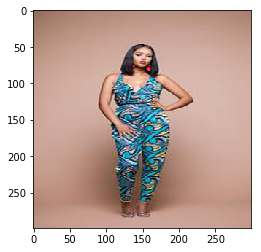

In [52]:
img_width, img_height = 299, 299
urls = tri_url_map[diff.index(0.015584418331854977)]

img = read_img(urls[0]) # reads an image link into a NumPy array...
n1p_img = resize_img_to_array(img, img_shape=(img_width, img_height))
imshow(n1p_img)



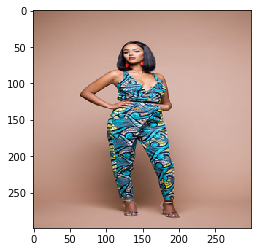

In [53]:
img_1 = read_img(urls[1]) # reads an image link into a NumPy array...
n2p_img = resize_img_to_array(img_1, img_shape=(img_width, img_height))
imshow(n2p_img)

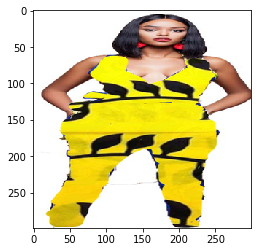

In [54]:

img3 = read_img(urls[2]) # reads an image link into a NumPy array...
n3p_img = resize_img_to_array(img3, img_shape=(img_width, img_height))
imshow(n3p_img)


In [61]:
#print diff.index(0.015584418331854977)
#calc_diff(diff.index(0.015584418331854977))
calc_diff(10) 

diff:  10.184879065491259 53.19095426797867 43.00607520248741


In [60]:
def calc_diff (index):
    pos_diff = (np.linalg.norm(semi_hard_triplets[index][0]) - np.linalg.norm(semi_hard_triplets[index][1]))**2
    neg_diff = (np.linalg.norm(semi_hard_triplets[index][0]) - np.linalg.norm(semi_hard_triplets[index][2]))**2
    print "diff: ", pos_diff, neg_diff,  neg_diff- pos_diff 
    
    

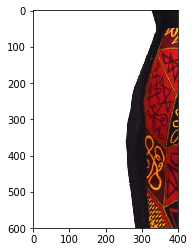

In [35]:
im = Image.open(pos)
crop_rectangle = (200, 400, 600, 1000)
cropped_im = im.crop(crop_rectangle)
imshow(cropped_im)


In [78]:
def get_conv_feat_img (cropped_im, model):
    np_img = resize_img_to_array(cropped_im, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    new_shape = (X_conv.shape[0], np.prod(X_conv.shape[1:]))
    X_conv_2d = X_conv.reshape(new_shape)
    return X_conv_2d

In [79]:
model_2 = make_resnet_conv(input_shape=[img_width, img_height, 3])
feat = get_conv_feat_img(cropped_im, model_2)
delete_model(model_2)

    

In [80]:
np.sum(np.abs(tri_feats[0] - feat))

947.62915

In [36]:
#positive 
#numpy.sum((A[:,:,0:3]-B[:,:,0:3])**2)
np.linalg.norm(tri_feats[0] - tri_feats[1])**2

754.7440118369159

In [37]:
#negative 
np.linalg.norm(tri_feats[0] - tri_feats[2])**2

987.2760948751566

In [75]:
cat_urls.index("/Users/robelmengistu/Documents/CS230_project/data/women/women-skirts/468149363/2AmsaAfricanPrintMidiSkirtwithSashYellowBlue.jpeg")

2959

In [92]:
cat_2d_feat = np.asarray(cat_feats)

(4501, 2048)


In [95]:
#Training KNN on 100K images w/ 2K features takes about 2 minutes!
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=30, n_jobs=8, algorithm='ball_tree')
knn.fit(cat_2d_feat)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=8, n_neighbors=30, p=2, radius=1.0)

In [18]:
#knn.kneighbors([X, 8, return_distance=True])

In [96]:
#serialize 
from sklearn.externals import joblib
knn_file = 'triplet_cate.pkl'
joblib.dump(knn, knn_file)

['triplet_cate.pkl']

In [97]:
def get_conv_feats(f, model):
    '''
    Converts an image (str of path or url) to a 2d convolutional features AKA logit.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    new_shape = (X_conv.shape[0], np.prod(X_conv.shape[1:]))
    X_conv_2d = X_conv.reshape(new_shape)
    return X_conv_2d

In [103]:
def get_n_set():
    n_set = []
    for train_data in cat_2d_feat: 
        n_set.append(knn.kneighbors(train_data.reshape(1, train_data.shape[0]), return_distance=True))
        if len(n_set) % 500 == 0:
            print len(n_set)
    return n_set

In [104]:
train_n_set = get_n_set()

500
1000
1500
2000
2500
3000
3500
4000


In [127]:
def plot_neighbors(url, neighbors, cat_urls, top=8, per_row=4):
    CATEGORY_INDEX = 7   #TODO: change depending on data location 
    path_split = url.split("/")
    query_category = path_split[7]
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    print "Query: ", query_category
    img = read_img(url) # reads an image link into a NumPy array...
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    imshow(np_img)
    
    c = 0 
    i = 0 
    product_recommended = []
    while (True):
        if c == top: break 
        if c % 4 == 0:
             _ , ax = plt.subplots(1, per_row, sharex='col', sharey='row', figsize=(24, 6))
        j = c % 4
        k = neighbors[1][0][i]

        #path = datadir + J['gender'][k] + "/" +J['category'][k]+ "/" +str (J['product_id'][k])+"/" + J['filename'][k]

        pd_id = cat_urls[k].split("/")[CATEGORY_INDEX + 1]
        pd_cat = cat_urls[k].split("/")[CATEGORY_INDEX] 
        path = cat_urls[k]
        image = read_img(path)
        if pd_id in product_recommended: 
            i += 1
            continue
        i += 1
        c += 1
        product_recommended.append(pd_id)
        score = accuracy_score (query_category, pd_cat, top)
        
        image = resize_img_to_array(image, img_shape=(img_width, img_height))
        ax[j].imshow(image)
        ax[j].axis('off')    
        ax[j].annotate(pd_cat + "   score: "+ str(score * top)+ "  "+str(distance[i - 1]),
                      (0,0), (0, -32), xycoords='axes fraction', 
                       textcoords='offset points', va='top')
  

        

In [174]:
# calc the mean avg. precision
def get_triplets(url, neighbors, cat_urls, num_rec=8, per_row=4):
    path_split = url.split("/")
    CATEGORY_INDEX = 7   #TODO: change depending on data location 
    PID_INDEX = 8
    query_category = path_split[CATEGORY_INDEX]
    #print "query_category: ", query_category
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    c = 0 
    i = 0 
   # MAP = 0 
   # accuracy = [] 
    #product_recommended = []
    neg_count = 0 
    neg_paths = []
    pos_paths = []
    while (True):
        if c == num_rec: break 
        k = neighbors[1][0][i]
        #print k, X_train['product_id'][k]

        pd_id = cat_urls[k].split("/")[PID_INDEX]
        pd_cat = cat_urls[k].split("/")[CATEGORY_INDEX] 
#         if pd_id in product_recommended: 
#             i += 1
#             continue
        
#         accuracy.append(accuracy_score(query_category, pd_cat, num_rec)
#         MAP += (sum(accuracy)/len(accuracy))
#        print c, ": ", pd_cat
        
        if pd_cat == query_category: pos_paths.append(cat_urls[k])
        else: neg_paths.append(cat_urls[k])
        
        i += 1
        c += 1
        #product_recommended.append(pd_id)
    
    
    return neg_paths[:4], pos_paths[-4:]

In [209]:
def generate_triplets(anchor, neg_paths, pos_paths):
    for neg in neg_paths:
        for pos in pos_paths:
           all_triplets.append((anchor, neg, pos))     

In [210]:
all_triplets = []
for i in range(len(cat_urls)):
    neg_paths, pos_paths = get_triplets (cat_urls[i], train_n_set[i], cat_urls, num_rec=25)
    generate_triplets(cat_urls[i], neg_paths, pos_paths)
    if i % 500 == 0: print i
print "total triplets: ", len(all_triplets)

0
500
1000
1500
2000
2500
3000
3500
4000
total triplets:  60628


In [143]:
# anchor 
# hard positives, least similar pos [4]
#3 * 4 = 12 * 4000
# hard negatives, most similar neg [4]
# 4229 * 4 * 4 = 67664
# 1.5K train, 1.5K test 

In [222]:
print all_triplets[1]

('/Users/robelmengistu/Documents/CS230_project/data/men/men-blazers/1804512449oo/01804512449oo.jpeg', '/Users/robelmengistu/Documents/CS230_project/data/men/men-tops/2038847169oo/12038847169oo.jpeg', '/Users/robelmengistu/Documents/CS230_project/data/men/men-blazers/3961108679oo/03961108679oo.jpeg')


In [220]:
thefile = open("feats_file.txt", 'w')
for item in all_triplets:
  for url_p in item:
      thefile.write("%s\n" % url_p)

Query:  women-dresses


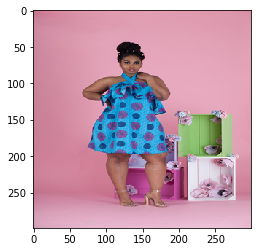

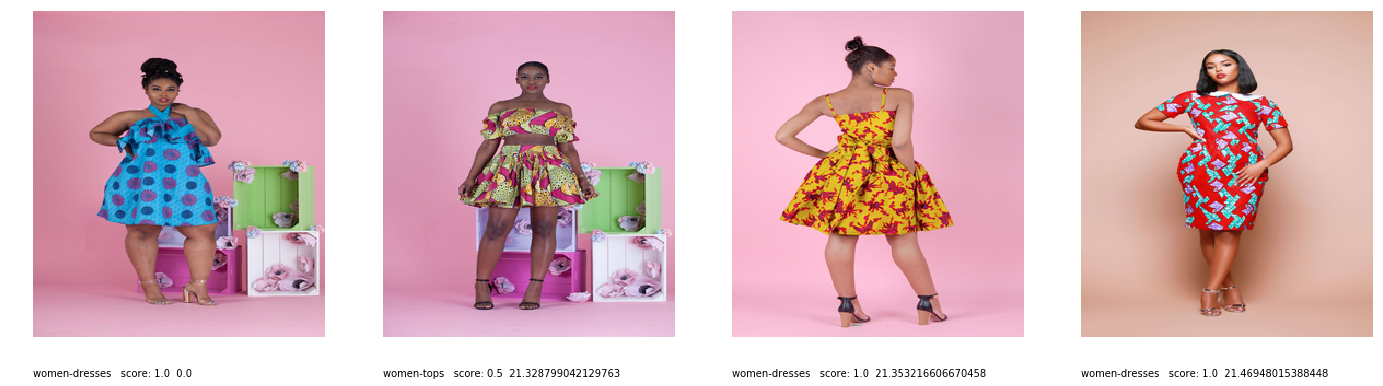

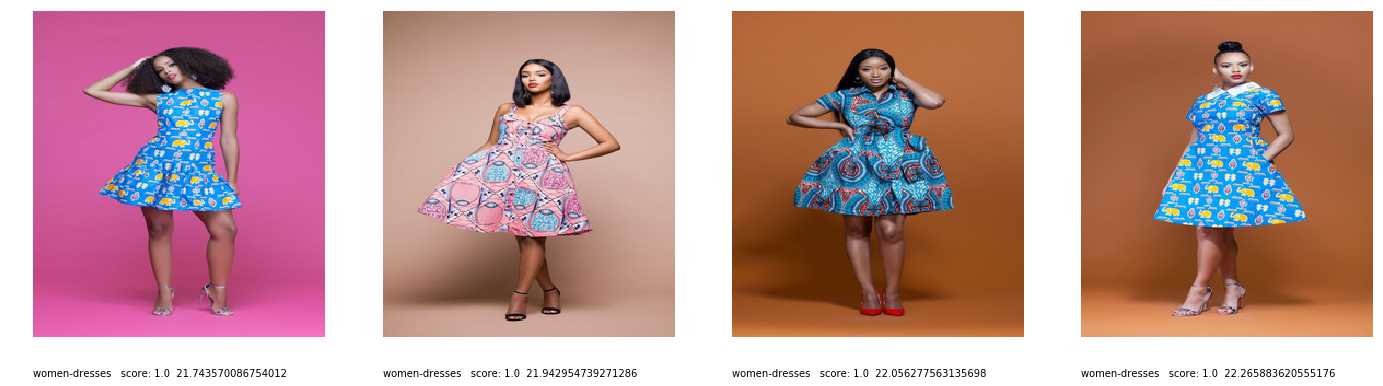

In [186]:
p = 411
num_rec =  8
plot_neighbors(cat_urls[p], train_n_set[p], cat_urls, top=num_rec, per_row=4)

In [55]:
# RUN FILE FROM HERE 

def get_neighbors(f, knn_file, top=8):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    
    X_conv_2d = get_conv_feats(f, model)
    print "X_conv_2d.shape", X_conv_2d.shape
    neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
    delete_model(model)
    return neighbors

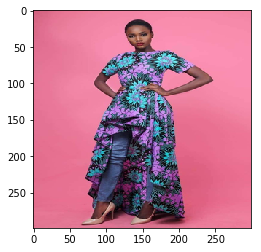

In [57]:
knn_file = 'afronet_conv_feats.pkl'
img_width, img_height = 299, 299
url = "/Users/robelmengistu/Documents/CS230_project/data/women/women-dresses/1MST6Z8Uafrikrea/01MST6Z8Uafrikrea.jpeg"
#url = '/Users/robelmengistu/Documents/CS230_project/data/women/women-jackets/1IURM78Safrikrea/21IURM78Safrikrea.jpeg'
#url = "/Users/robelmengistu/Documents/CS230_project/data/women/women-dresses/11887377615/4african-print-wekesa-midi-dress.jpeg"
img = read_img(url) # reads an image link into a NumPy array...
n1p_img = resize_img_to_array(img, img_shape=(img_width, img_height))
imshow(n1p_img)

In [58]:
neighbors = get_neighbors(url, knn_file, top=8)

/Users/robelmengistu/anaconda2/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator NearestNeighbors from version 0.18 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


X_conv_2d.shape (1, 2048)


In [25]:
def accuracy_score (q_cat, r_cat, num_rec): 

    match_score =  1.0/num_rec
    half_match_score = (1.0/(num_rec * 2))
    
    matching_sets = [["women-dresses","women-outerwear", "women-matching-sets"], ["women-tops", "women-jackets"]]
    
    half_match_set_1 = ["women-jumpsuits", "women-pants-and-shorts","women-matching-sets","women-dresses", "women-skirts"]
    half_match_set_2 = ["women-tops", "women-jackets", "women-dresses", "women-matching-sets", "women-outerwear"]
    
    
    match_tuples = []
    for ms in matching_sets:
        for i in ms:
            for j in ms:
                if i != j: match_tuples.append((i,j))
    
    half_match_tuples = []
    for hs in [half_match_set_1, half_match_set_2]:
        for i in hs:
            for j in hs:
                if i != j: half_match_tuples.append((i,j))
    
    
    if r_cat == q_cat: return match_score
    if (r_cat, q_cat) in match_tuples: return match_score
    if (r_cat, q_cat) in half_match_tuples: return half_match_score
    return 0

In [79]:
# calc the mean avg. precision
def get_map(url, neighbors, J, num_rec=8, per_row=4):
    path_split = url.split("/")
    CATEGORY_INDEX = 7   #TODO: change depending on data location 
    query_category = path_split[7]
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    c = 0 
    i = 0 
    MAP = 0 
    accuracy = [] 
    product_recommended = []
    while (True):
        if c == num_rec: break 
        k = neighbors[1][0][i]
        #print k, X_train['product_id'][k]
        if J['product_id'][k] in product_recommended: 
            i += 1
            continue
        
        accuracy.append(accuracy_score(query_category, J['category'][k], num_rec))
        
        MAP += (sum(accuracy)/len(accuracy))
        
        i += 1
        c += 1
        product_recommended.append(J['product_id'][k])
    
    
    return MAP
        
        

In [77]:
def get_neighbors_set(f_set, knn_file):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    neighbors_set = []
    for f in f_set: 
        X_conv_2d = get_conv_feats(f, model)
        neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
        neighbors_set.append(neighbors)
    delete_model(model)
    return neighbors_set

In [78]:
CATEGORY = 6
PRODUCT_ID = 8
FILE_NAME = 9

datadir = '/Users/robelmengistu/Documents/CS230_project/data'
i = 0
products_added = []
test_urls = []

for subdir, dirs, files in os.walk(datadir):
    for img in files:
        if ".DS_" in img: continue
        path = subdir+"/" +img
        path_split = path.split("/")
        product = path_split[PRODUCT_ID]
        if "afrikrea" in product and product not in products_added:
            products_added.append(product)
            test_urls.append(path)
        else: 
            continue 
        i += 1
print len(test_urls)

4181


In [79]:
# Test Data
dresses_set = test_urls[:450]
other_set = test_urls[2750:3200]  # pants and shorts and skirts

In [80]:
dress_neighbors_set = get_neighbors_set(dresses_set, knn_file)

In [81]:
other_neighbors_set = get_neighbors_set(other_set, knn_file)

In [189]:
print "TEST SET RESULTS: "
num_rec = 8
dress_accuracy = 0 
acc_factor = 1.0/len(dresses_set)
for i in range(len(dresses_set)):
    if i == 324: 
        dress_accuracy += (0.5*acc_factor)
        continue
    acc = get_map(dresses_set[i], dress_neighbors_set[i], X_train, num_rec=num_rec, per_row=4)
    #if acc < 0.2: print i
    dress_accuracy += (acc*acc_factor)

print "Dress MAP: ", dress_accuracy


other_accuracy = 0

acc_factor = 1.0/len(other_set)
for i in range(len(other_set)):
    acc = get_map(other_set[i], other_neighbors_set[i], X_train, num_rec=num_rec, per_row=4)
    other_accuracy += (acc*acc_factor)
    if acc < 0.2: print i
    
print "Other MAP: ", other_accuracy
print "Overall MAP", (other_accuracy + dress_accuracy)/2.0

TEST SET RESULTS: 
Dress MAP:  0.735096560847
4
5
9
25
28
29
44
47
51
53
57
58
65
67
70
74
83
84
85
88
89
90
92
96
105
116
119
123
132
137
141
142
147
148
153
155
157
162
164
165
166
183
185
197
210
224
227
228
288
296
309
316
328
357
361
393
443
444
Other MAP:  0.477018683862
Overall MAP 0.606057622354
